In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot

from spike_statistics.core import permutation_resampling

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

19:42:33 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "longitudinal-comparisons-gridcells"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

action  baseline  entity  frequency      i    ii  session  \
0  1849-060319-3      True    1849        NaN  False  True        3   
1  1849-060319-3      True    1849        NaN  False  True        3   
2  1849-060319-3      True    1849        NaN  False  True        3   
3  1849-060319-3      True    1849        NaN  False  True        3   
4  1849-060319-3      True    1849        NaN  False  True        3   

  stim_location  stimulated          tag  ...  burst_event_ratio  \
0           NaN       False  baseline ii  ...           0.397921   
1           NaN       False  baseline ii  ...           0.146481   
2           NaN       False  baseline ii  ...           0.373466   
3           NaN       False  baseline ii  ...           0.097464   
4           NaN       False  baseline ii  ...           0.248036   

  bursty_spike_ratio  gridness  border_score  information_rate  \
0           0.676486 -0.459487      0.078474          0.965845   
1           0.277121 -0.615405      0.311180          0.191375   
2           0.658748 -0.527711      0.131660          3.833587   
3           0.196189 -0.641543      0.274989          0.153740   
4           0.461250 -0.085292      0.198676          0.526720   

   information_specificity  head_mean_ang head_mean_vec_len   spacing  \
0                 0.309723       5.788704          0.043321  0.624971   
1                 0.032266       1.821598          0.014624  0.753333   
2                 0.336590       4.407614          0.121115  0.542877   
3                 0.068626       6.128601          0.099223  0.484916   
4                 0.033667       1.602362          0.051825  0.646571   

   orientation  
0    22.067900  
1     0.000000  
2    27.758541  
3    11.309932  
4     0.000000  

[5 rows x 39 columns]

In [5]:
statistics['unit_day'] = statistics.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [6]:
stim_response_action = actions['stimulus-response']
stim_response_results = pd.read_csv(stim_response_action.data_path('results'))

In [7]:
statistics = pd.merge(statistics, stim_response_results, how='left')

In [8]:
print('N cells:',statistics.shape[0])

N cells: 1284


In [9]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

border_score  gridness  head_mean_ang  head_mean_vec_len  information_rate  \
0      0.348023  0.275109       3.012689           0.086792          0.707197   
1      0.362380  0.166475       3.133138           0.037271          0.482486   
2      0.367498  0.266865       5.586395           0.182843          0.271188   
3      0.331942  0.312155       5.955767           0.090786          0.354018   
4      0.325842  0.180495       5.262721           0.103584          0.210427   

   speed_score         action  channel_group  unit_name  
0     0.149071  1833-010719-1            0.0      127.0  
1     0.132212  1833-010719-1            0.0      161.0  
2     0.062821  1833-010719-1            0.0      191.0  
3     0.052009  1833-010719-1            0.0      223.0  
4     0.094041  1833-010719-1            0.0      225.0

In [10]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

action  baseline  entity  frequency      i    ii  session  \
0  1849-060319-3      True    1849        NaN  False  True        3   
1  1849-060319-3      True    1849        NaN  False  True        3   
2  1849-060319-3      True    1849        NaN  False  True        3   
3  1849-060319-3      True    1849        NaN  False  True        3   
4  1849-060319-3      True    1849        NaN  False  True        3   

  stim_location  stimulated          tag  ...  p_e_peak t_i_peak  p_i_peak  \
0           NaN       False  baseline ii  ...       NaN      NaN       NaN   
1           NaN       False  baseline ii  ...       NaN      NaN       NaN   
2           NaN       False  baseline ii  ...       NaN      NaN       NaN   
3           NaN       False  baseline ii  ...       NaN      NaN       NaN   
4           NaN       False  baseline ii  ...       NaN      NaN       NaN   

   border_score_threshold  gridness_threshold  head_mean_ang_threshold  \
0                0.332548            0.229073                 6.029431   
1                0.354830            0.089333                 6.120055   
2                0.264610           -0.121081                 5.759406   
3                0.344280            0.215829                 6.033364   
4                0.342799            0.218967                 5.768170   

   head_mean_vec_len_threshold information_rate_threshold  \
0                     0.205362                   1.115825   
1                     0.073566                   0.223237   
2                     0.150827                   4.964984   
3                     0.110495                   0.239996   
4                     0.054762                   0.524990   

   speed_score_threshold  specificity  
0               0.066736     0.445206  
1               0.052594     0.097485  
2               0.027120     0.393687  
3               0.054074     0.262612  
4               0.144702     0.133677  

[5 rows x 51 columns]

# Statistics about all cell-sessions

In [11]:
data.groupby('stimulated').count()['action']

stimulated
False    624
True     660
Name: action, dtype: int64

# Find all cells with gridness above threshold

In [12]:
query = 'gridness > gridness_threshold and information_rate > information_rate_threshold'
sessions_above_threshold = data.query(query)
print("Number of gridcells", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of gridcells 225
Number of animals 4


In [13]:
columns = [
    'average_rate', 'gridness', 'sparsity', 'selectivity', 'information_specificity',
    'max_rate', 'information_rate', 'interspike_interval_cv', 
    'in_field_mean_rate', 'out_field_mean_rate', 
    'burst_event_ratio', 'specificity', 'speed_score'
]

## select neurons that have been characterized as a grid cell on the same day

In [14]:
once_a_gridcell = statistics[statistics.unit_day.isin(sessions_above_threshold.unit_day.values)]

# divide into stim not stim

In [15]:
baseline_i = once_a_gridcell.query('baseline and Hz11')
stimulated_11 = once_a_gridcell.query('stimulated and frequency==11 and stim_location=="ms"')

baseline_ii = once_a_gridcell.query('baseline and Hz30')
stimulated_30 = once_a_gridcell.query('stimulated and frequency==30 and stim_location=="ms"')

print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 76
Number of gridcells in stimulated 11Hz ms sessions 68
Number of gridcells in baseline ii sessions 64
Number of gridcells in stimulated 30Hz ms sessions 52


# Plotting
## TODO select units that are grid in baseline i

In [16]:
max_speed = 1, # m/s only used for speed score
min_speed = 0.02, # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size = 0.02
smoothing_low = 0.03
smoothing_high = 0.06

In [17]:
data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size
)

In [18]:
results_corr = [[], [], []]
results_gridness = [[], [], []]
results_unit_name = [[], [], []]
results_unit_id = [[], [], []]
results_id_map = {}
for nid, unit_sessions in once_a_gridcell.groupby('unit_id'):
    base_i = unit_sessions.query("baseline and Hz11")
    base_ii = unit_sessions.query("baseline and Hz30")
    stim_i = unit_sessions.query("frequency==11")
    stim_ii = unit_sessions.query("frequency==30")
    dfs = [(base_i, base_ii), (base_i, stim_i), (base_ii, stim_ii)]
    for i, pair in enumerate(dfs):
        for (_, row_1), (_, row_2) in zip(pair[0].iterrows(), pair[1].iterrows()):
            rate_map_1 = data_loader.rate_map(
                row_1['action'], row_1['channel_group'], row_1['unit_name'], smoothing_low)
            rate_map_2 = data_loader.rate_map(
                row_2['action'], row_2['channel_group'], row_2['unit_name'], smoothing_low)
            results_corr[i].append(np.corrcoef(rate_map_1.ravel(), rate_map_2.ravel())[0,1])
            results_gridness[i].append((row_1.gridness, row_2.gridness))
            results_unit_name[i].append((
                f'{row_1.action}_{row_1.channel_group}_{row_1.unit_name}', 
                f'{row_2.action}_{row_2.channel_group}_{row_2.unit_name}'))
            assert row_1.unit_id == row_2.unit_id
            uid = row_2.unit_id
            idnum = row_1.unit_idnum
            results_id_map[uid] = idnum
            results_unit_id[i].append(idnum)

In [19]:
def session_id(row):
    if row.baseline and row.i:
        n = 0
    elif row.stimulated and row.i:
        n = 1
    elif row.baseline and row.ii:
        n = 2
    elif row.stimulated and row.ii:
        n = 3
    else:
        raise ValueError('what')
    return n
        
once_a_gridcell['session_id'] = once_a_gridcell.apply(session_id, axis=1)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


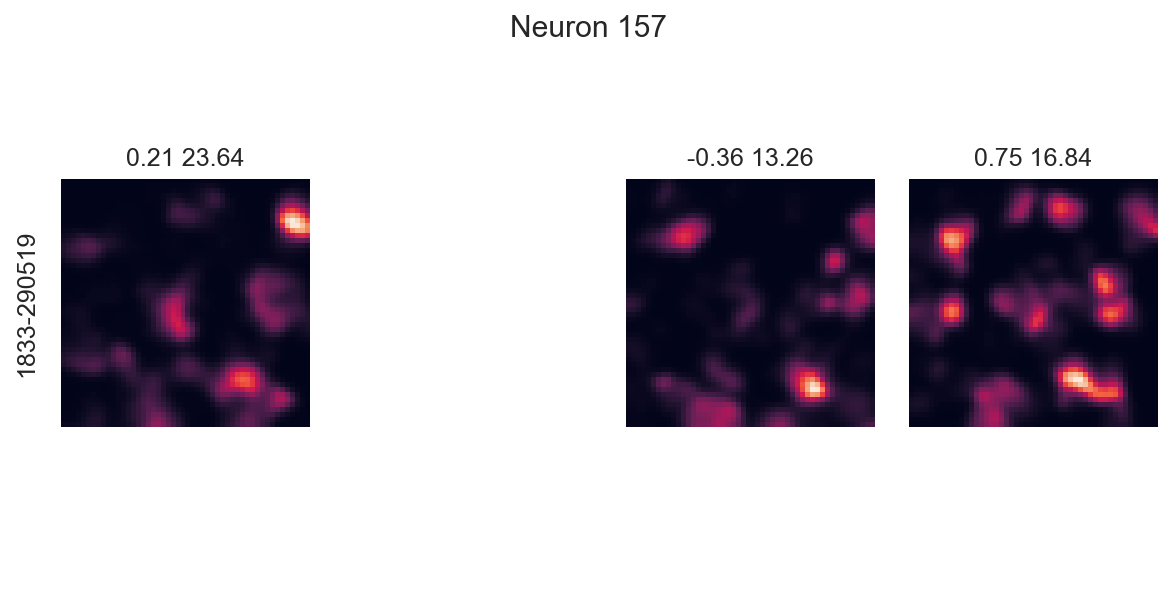

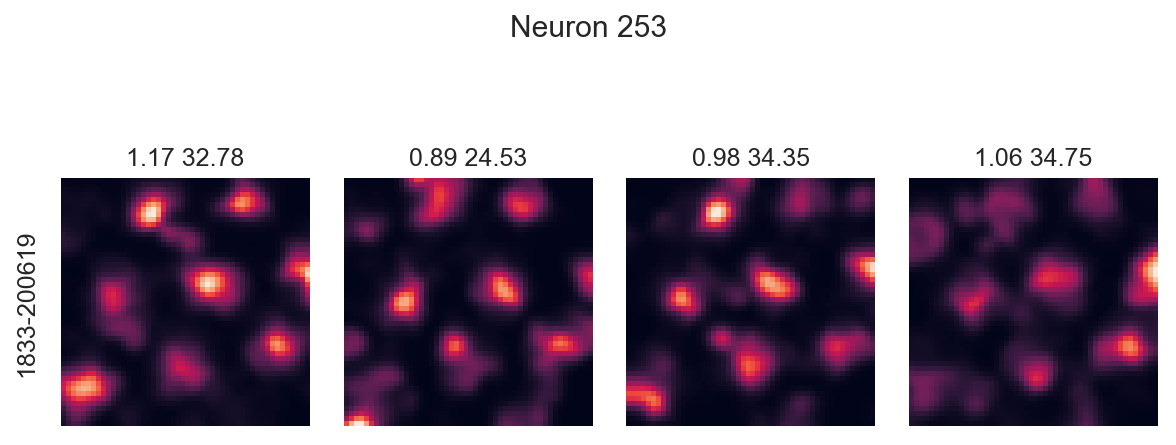

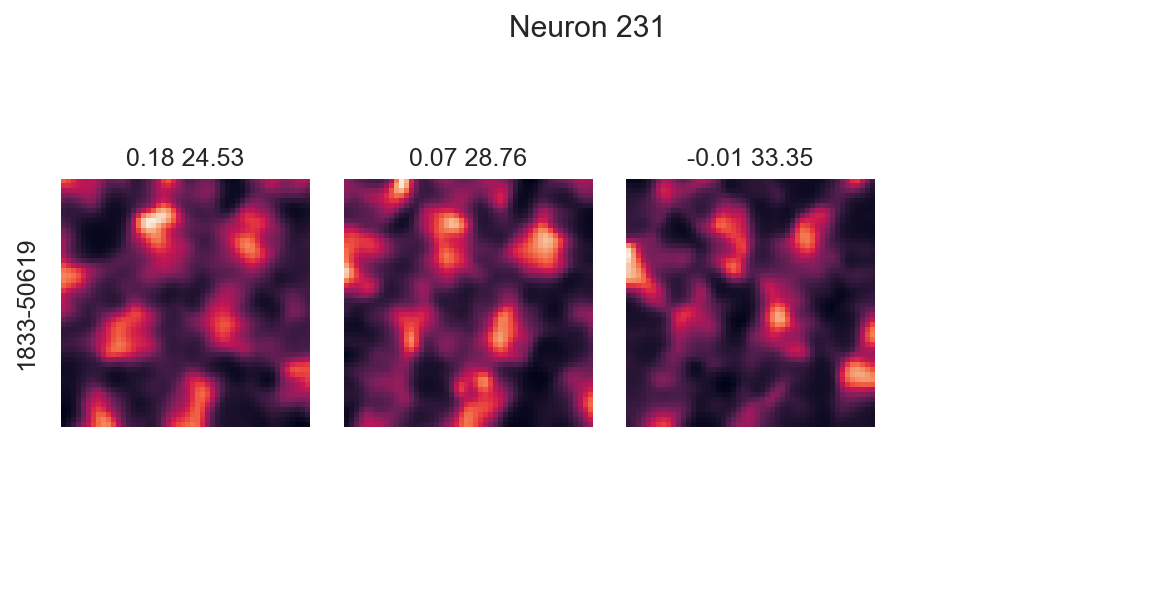

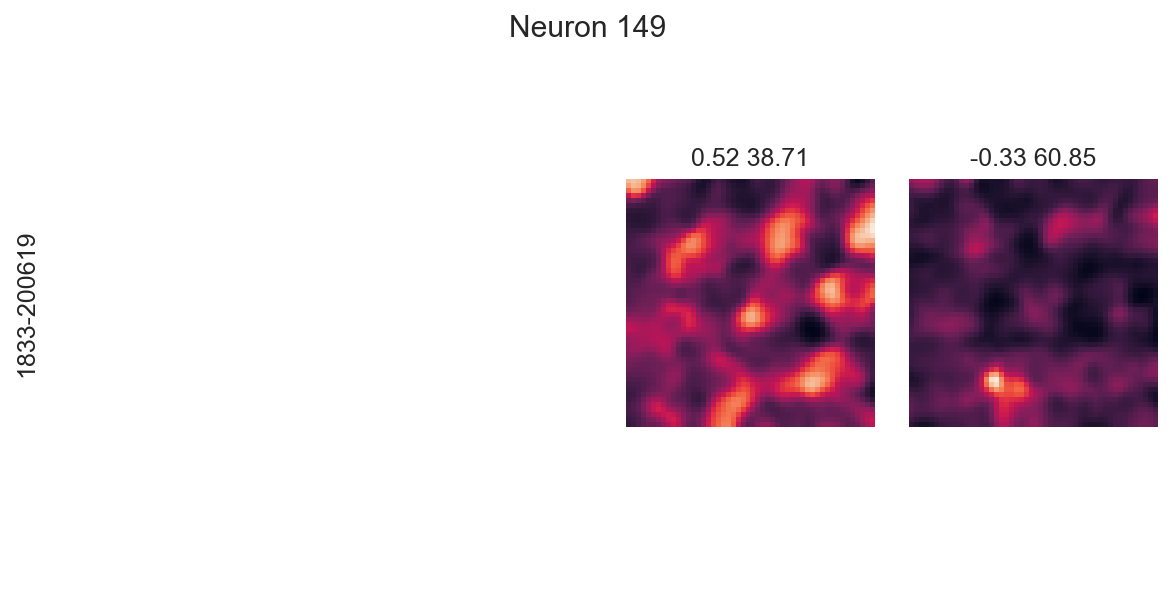

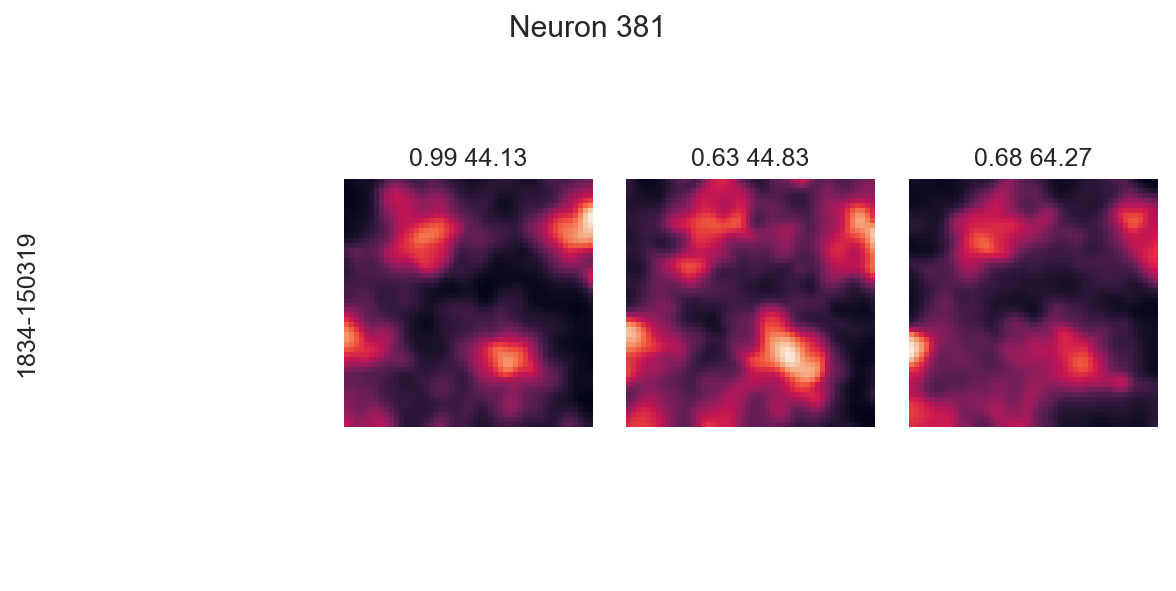

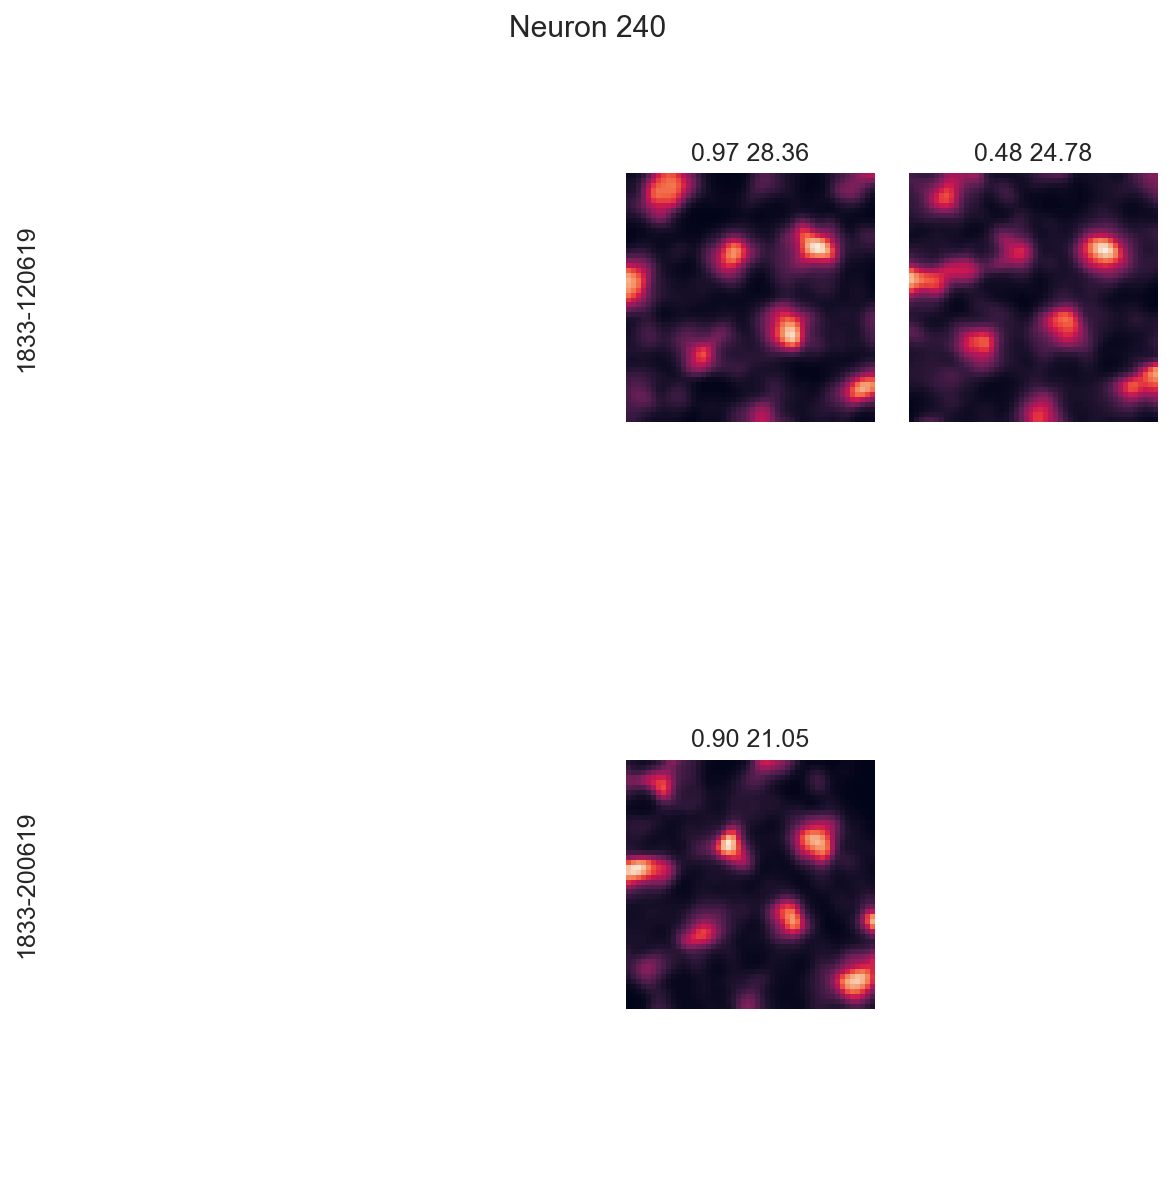

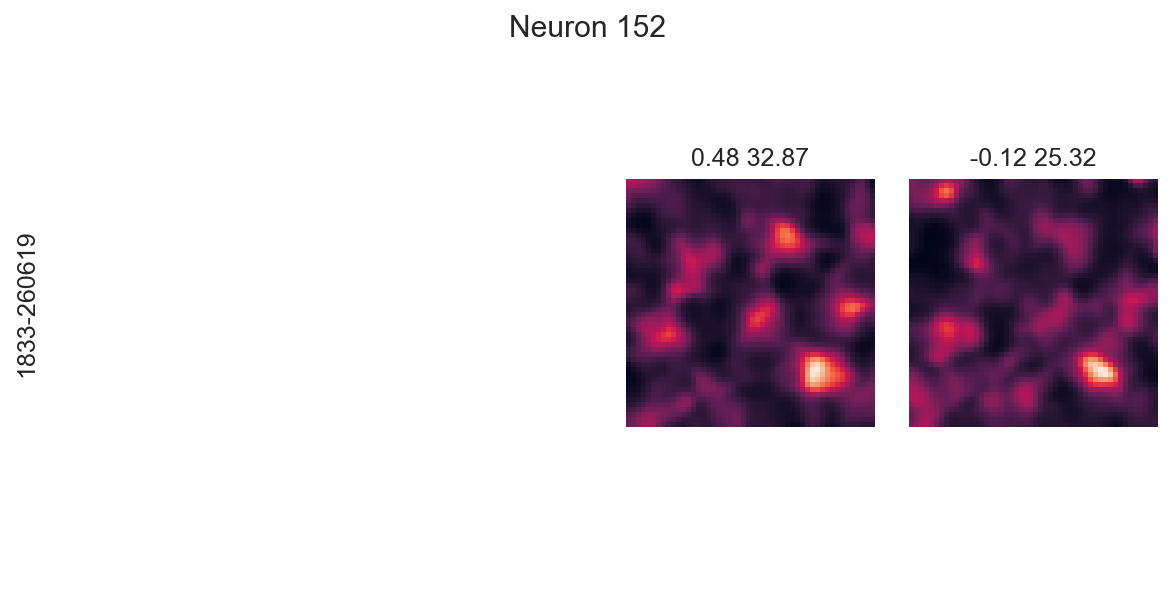

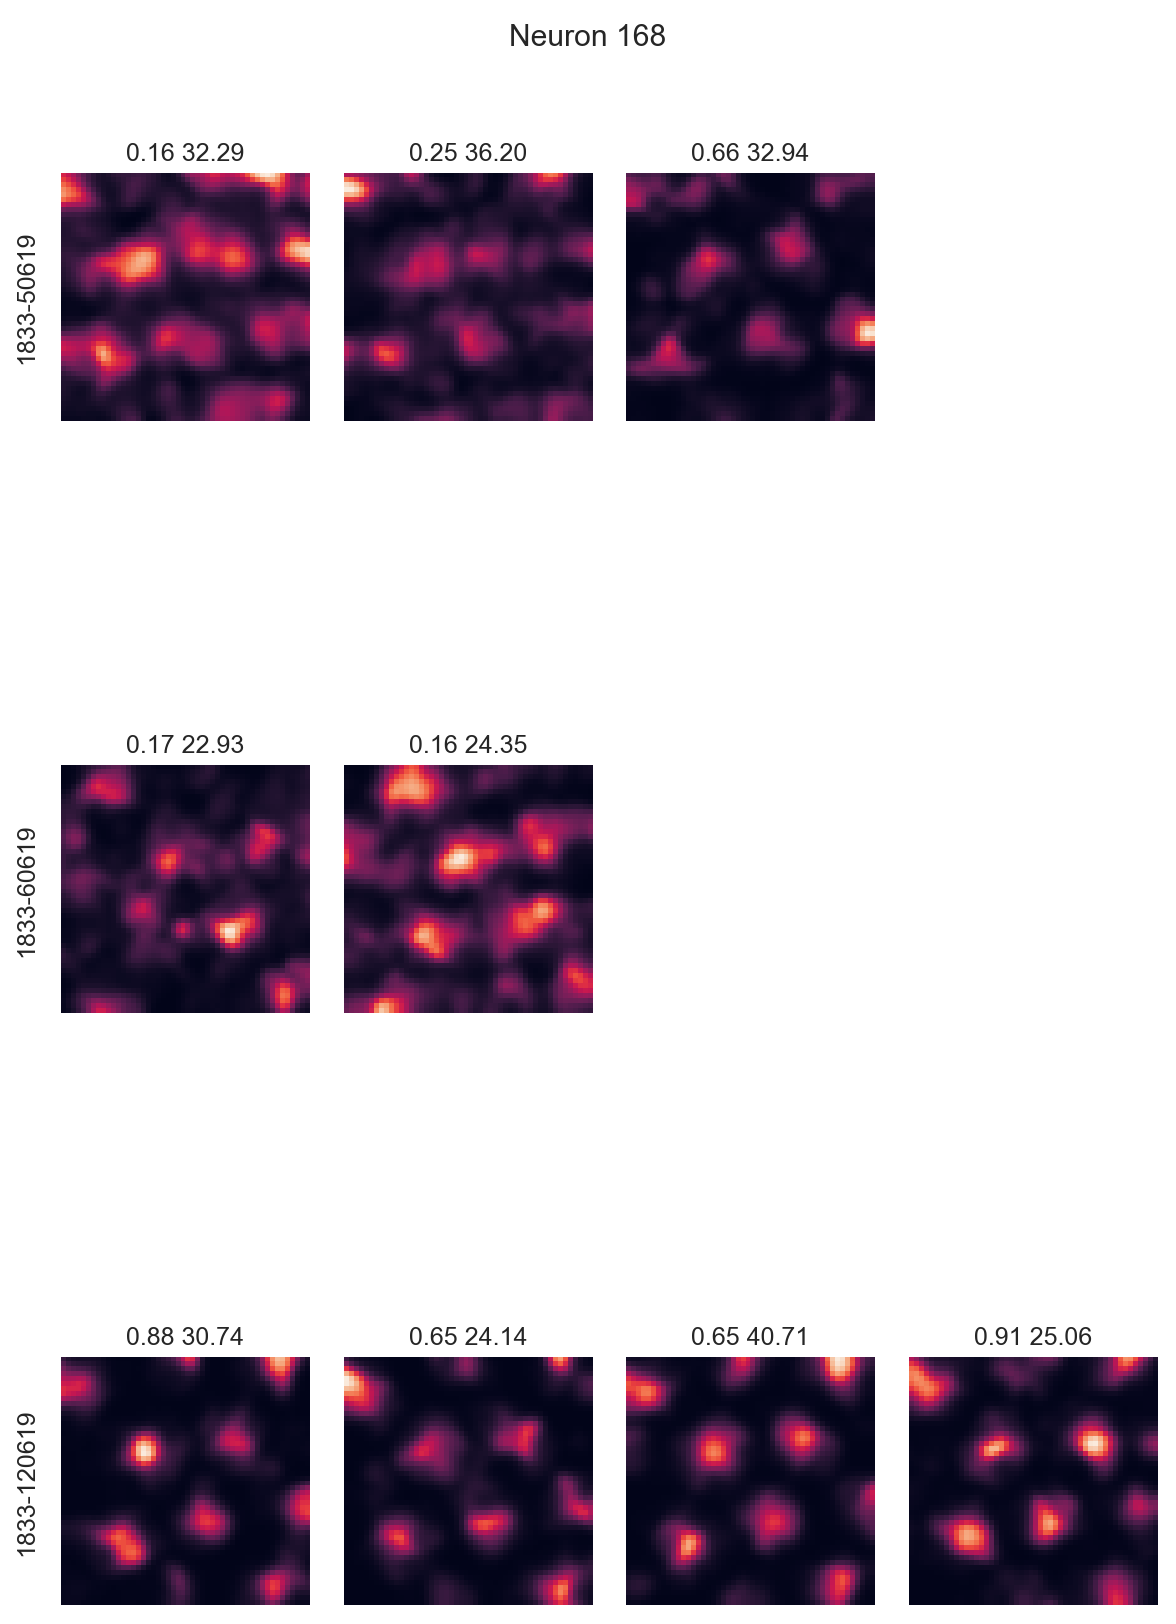

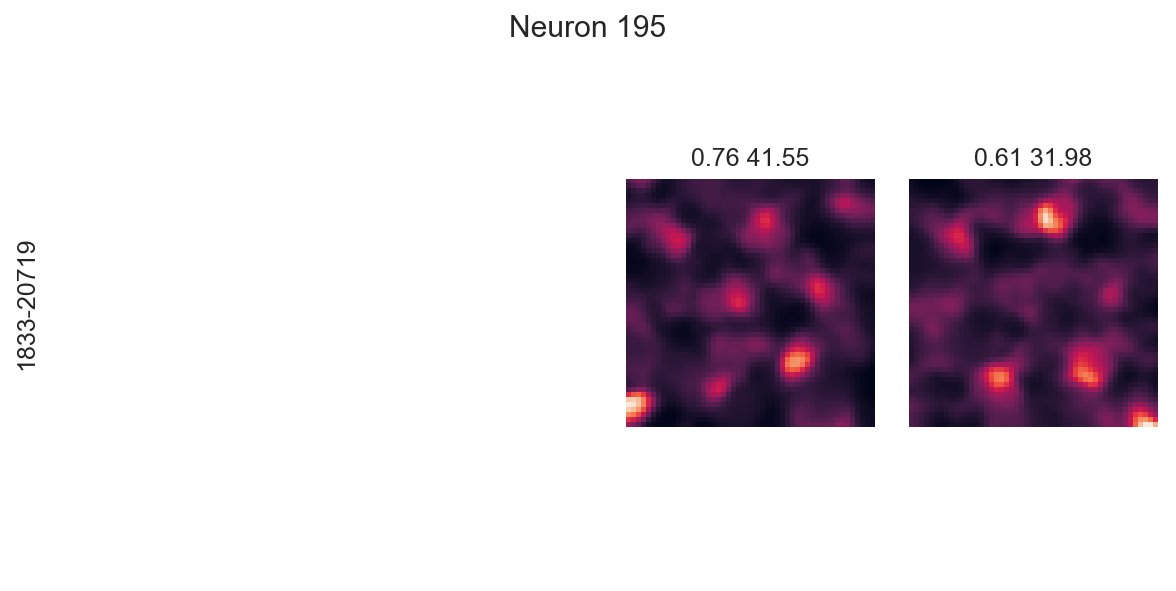

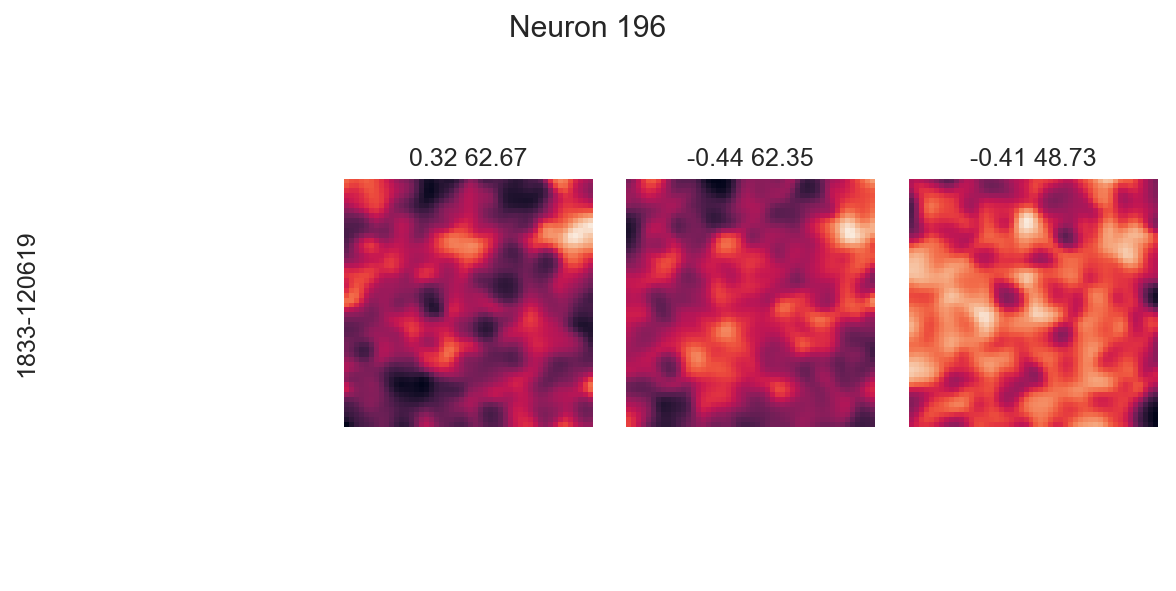

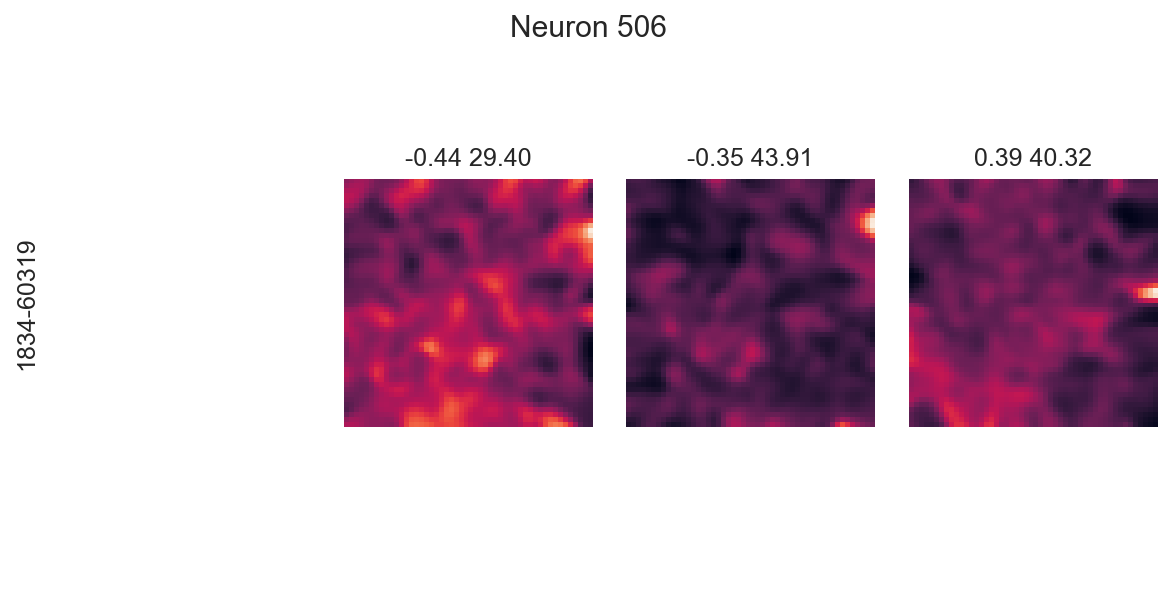

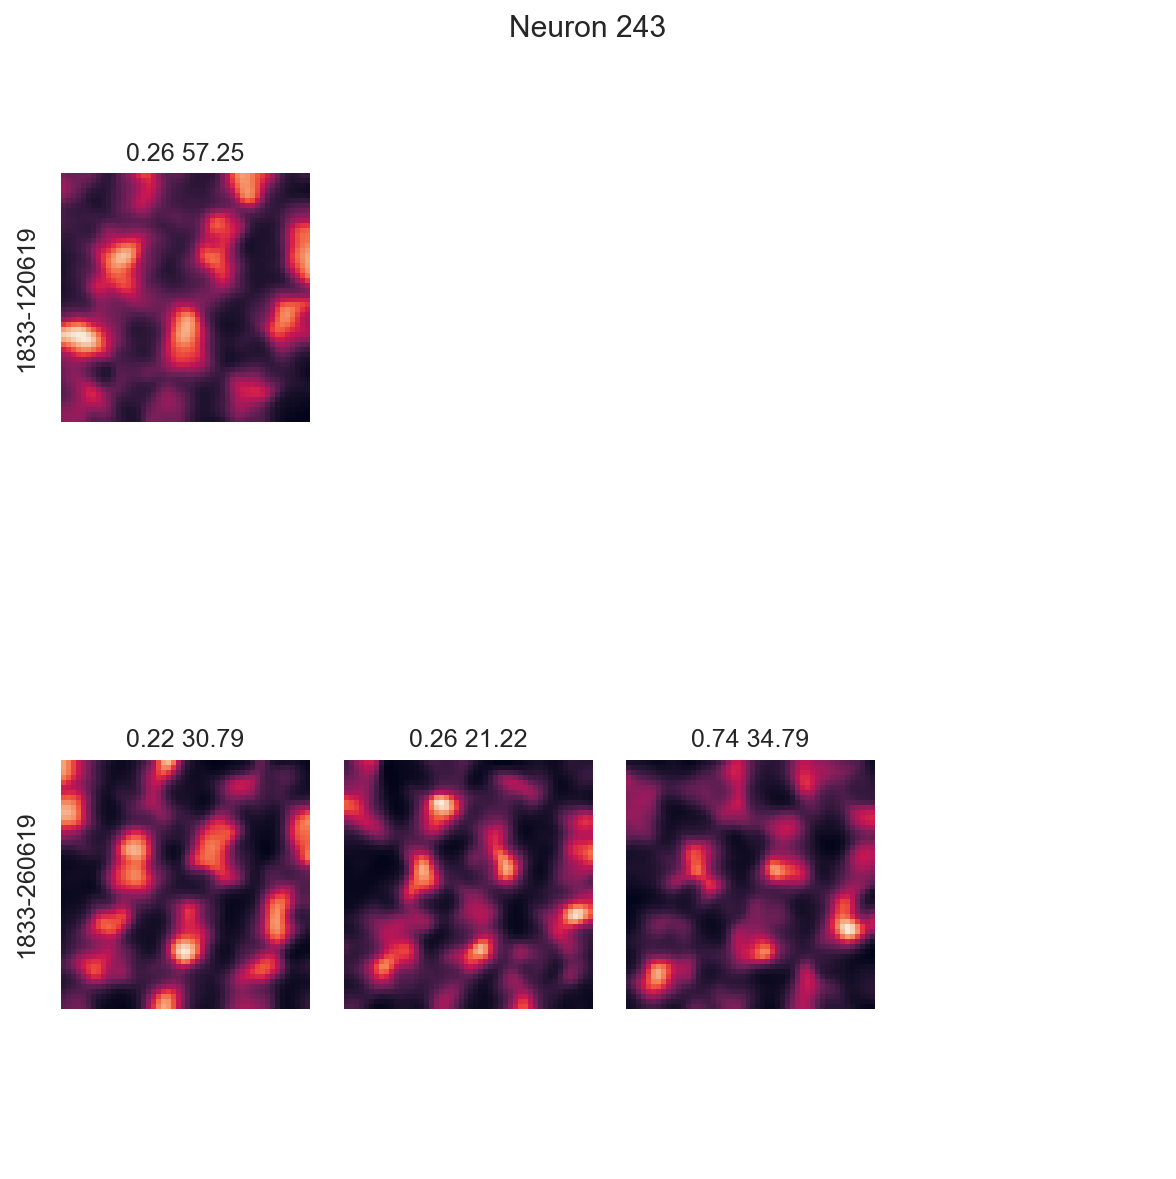

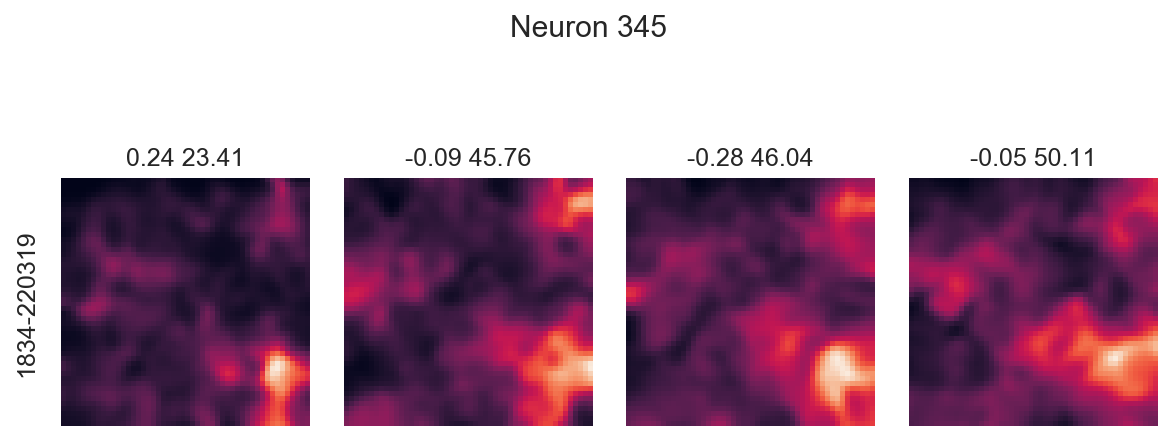

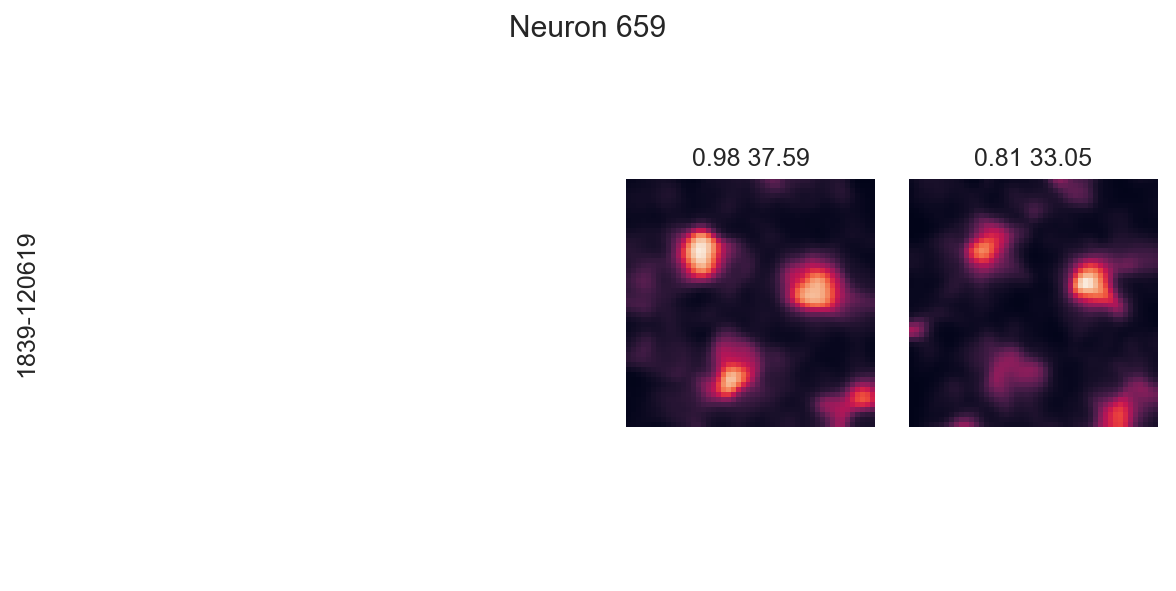

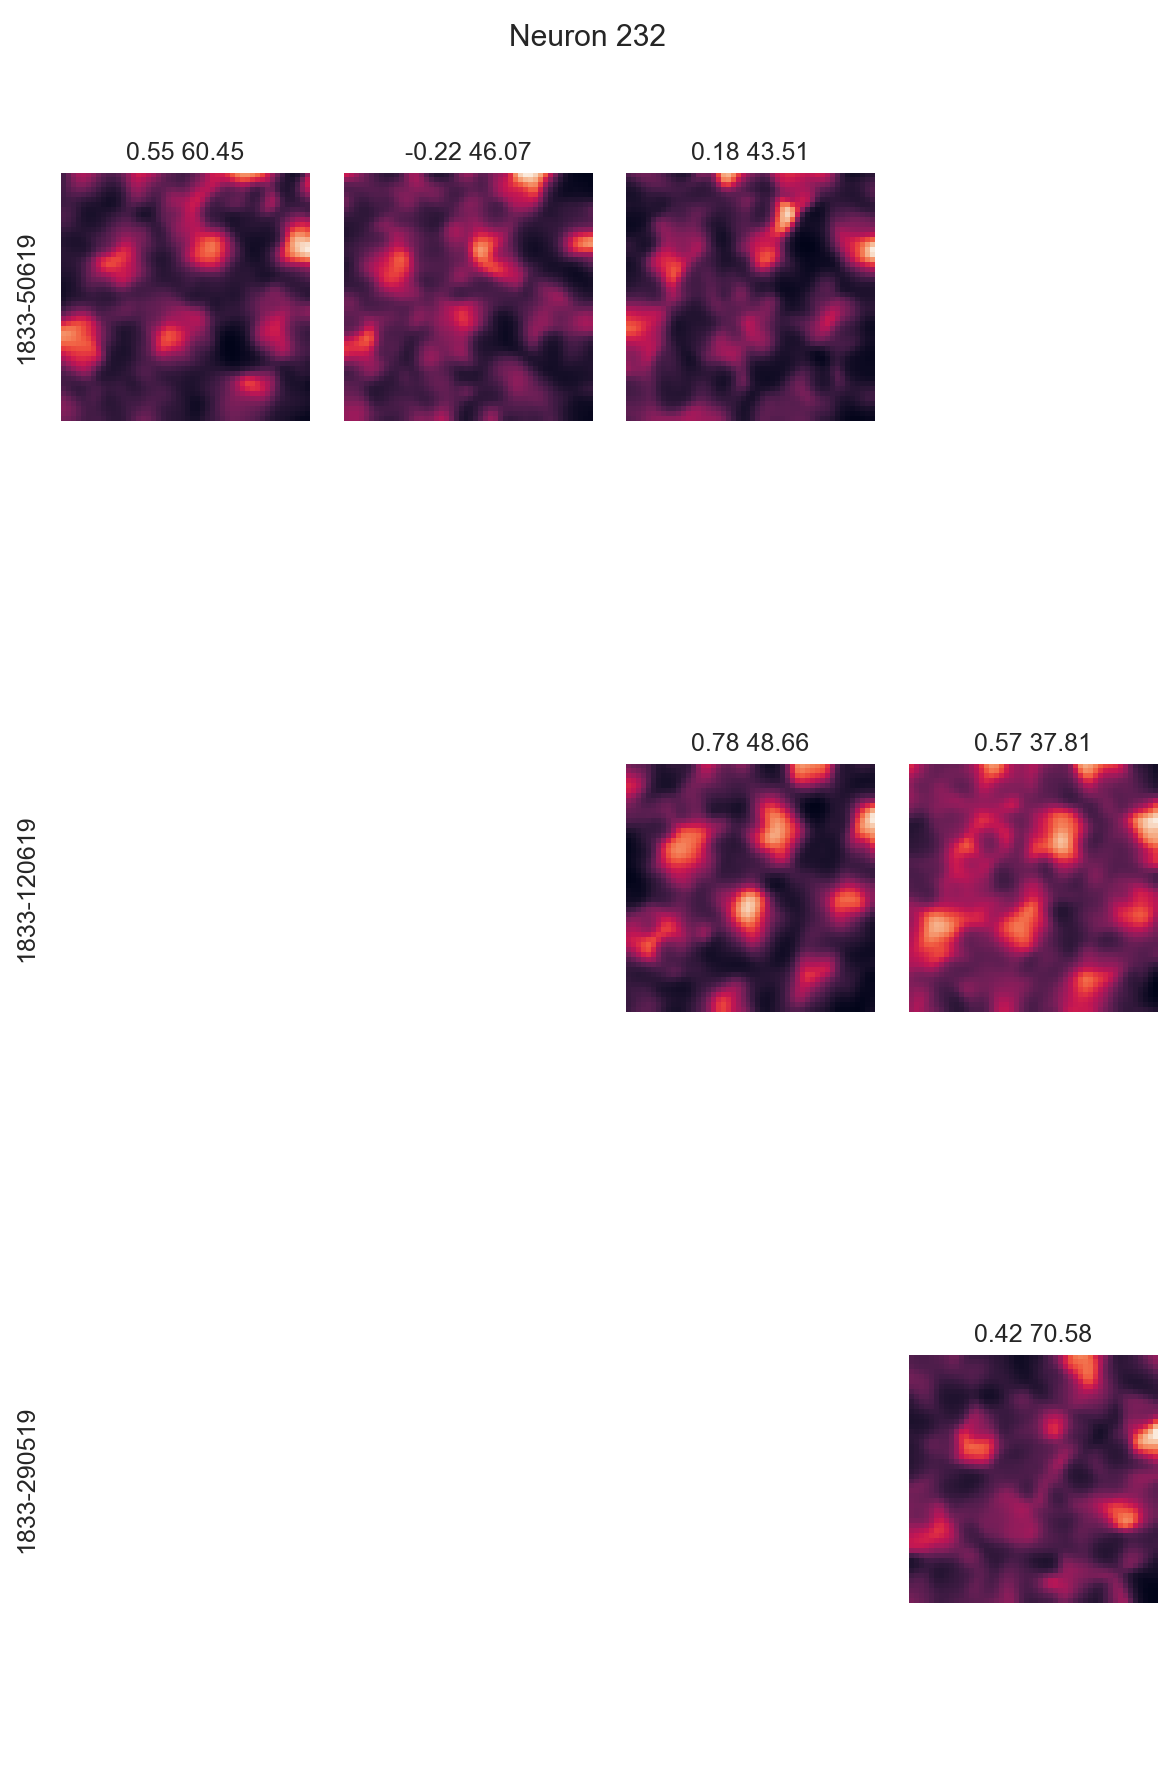

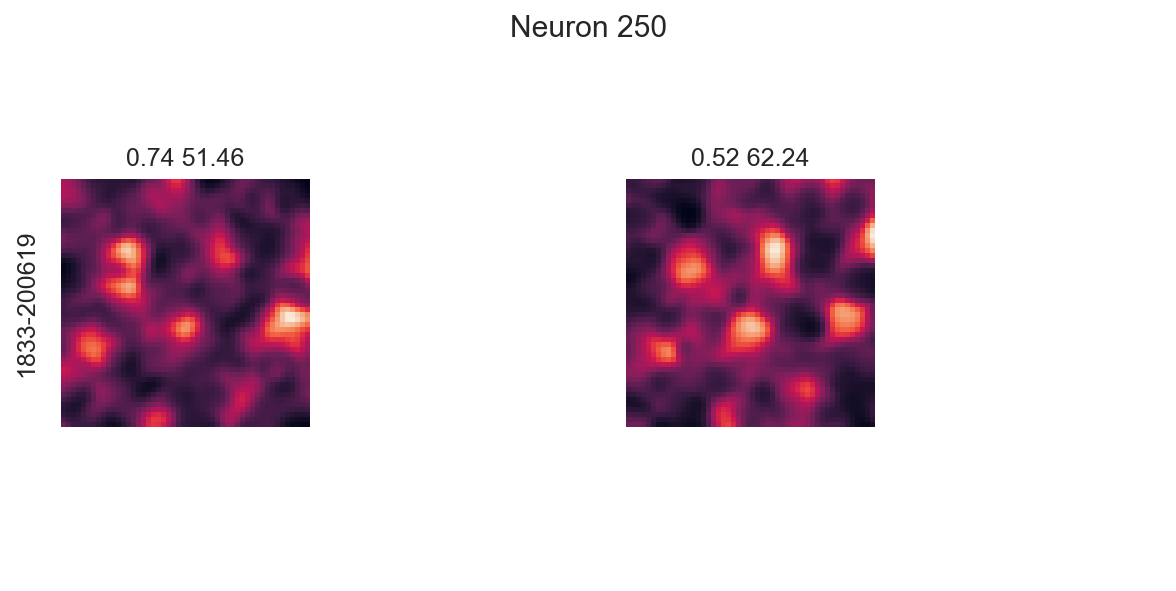

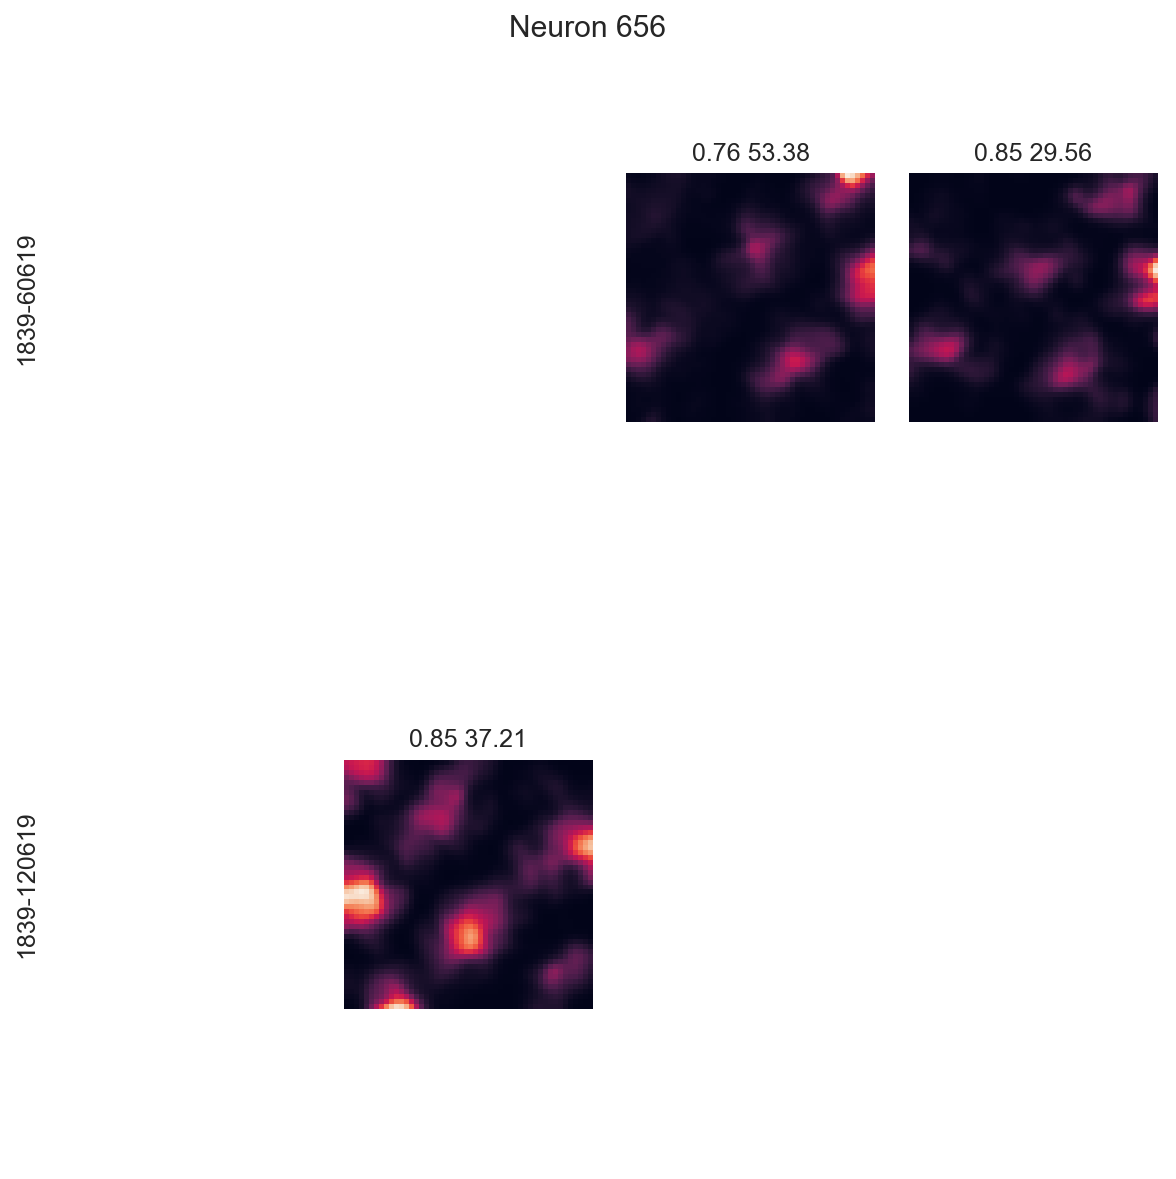

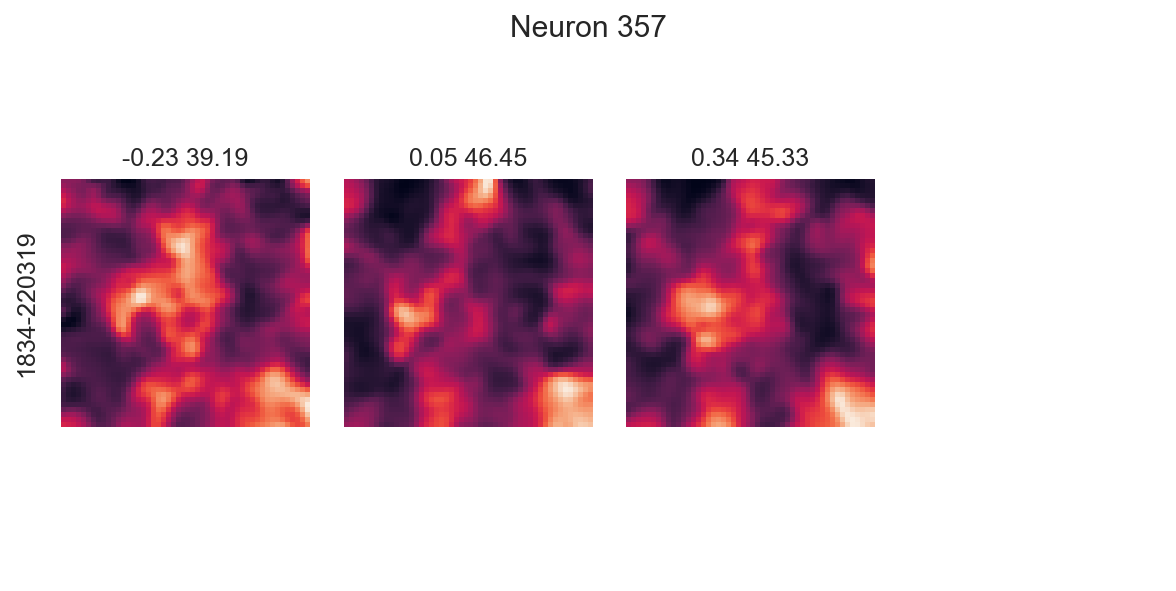

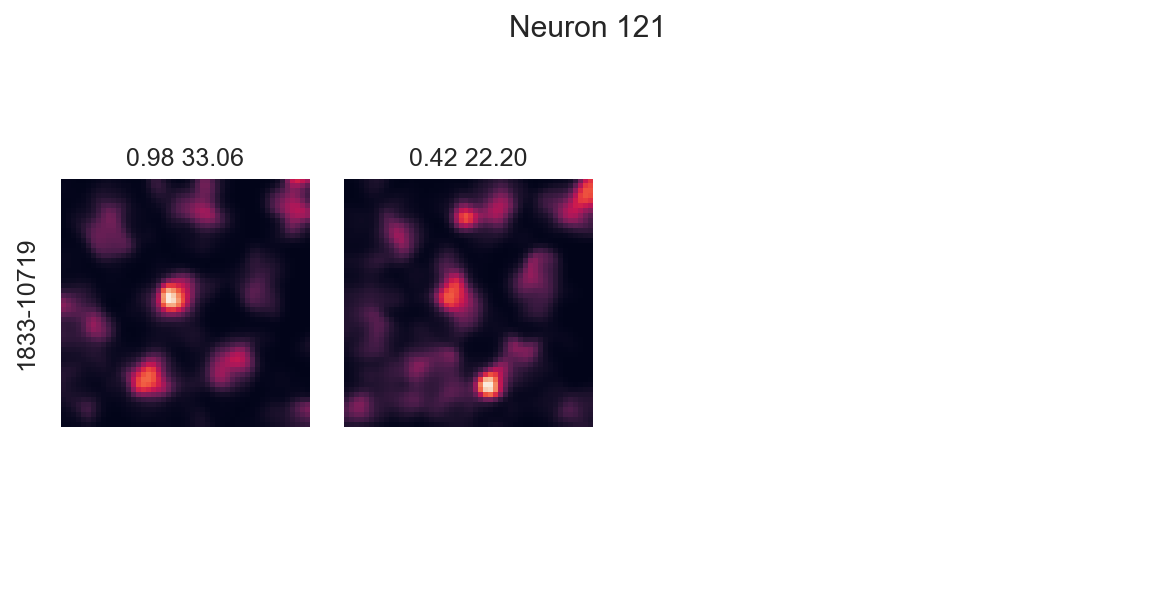

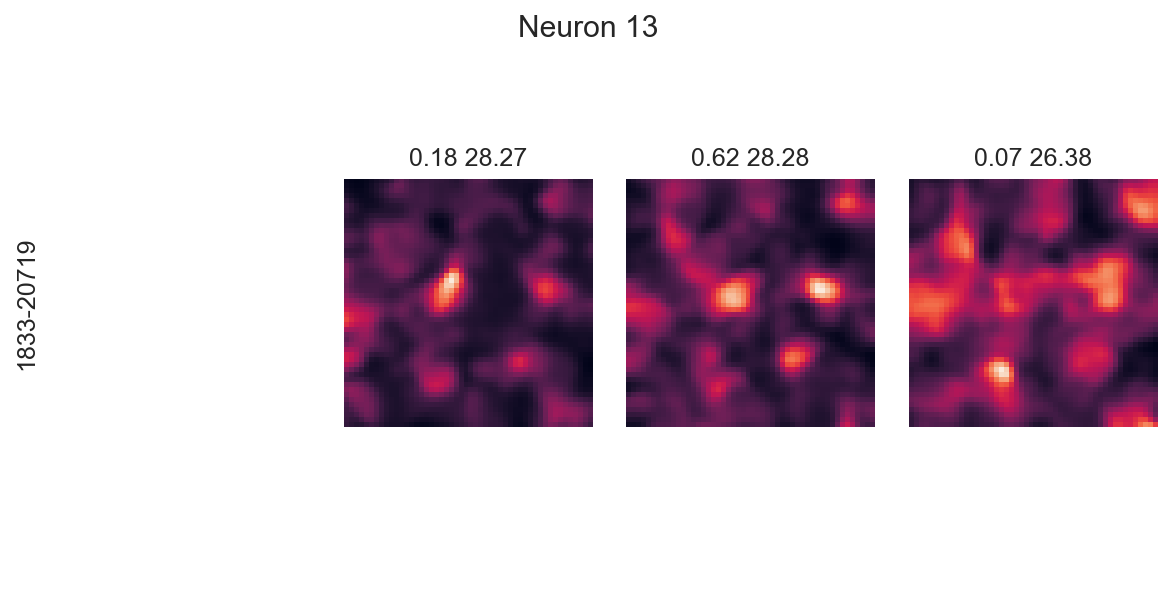

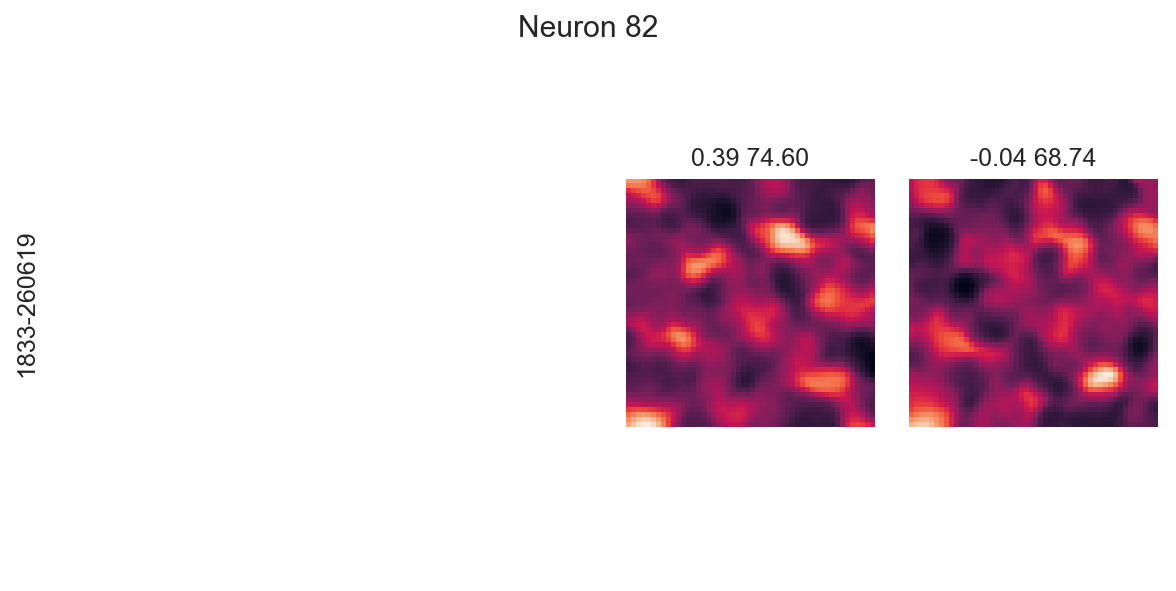

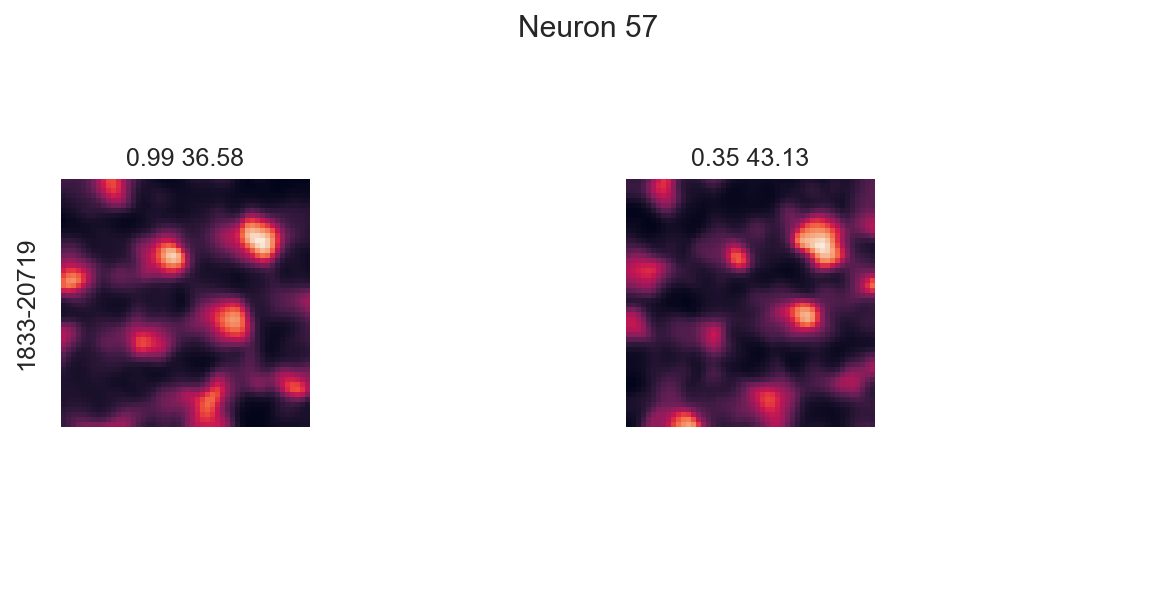

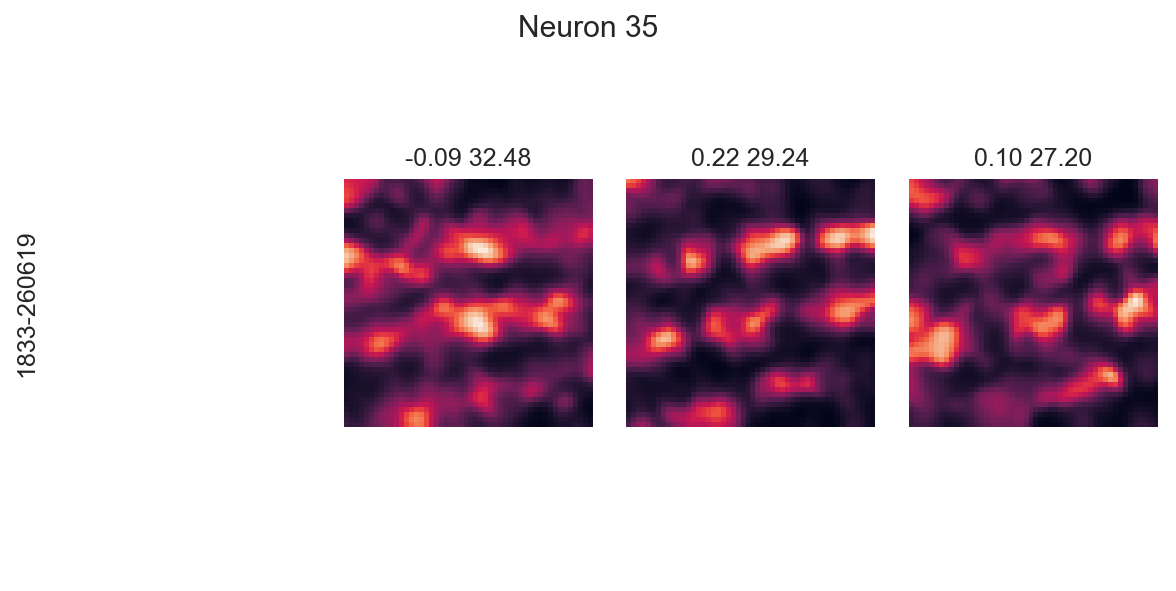

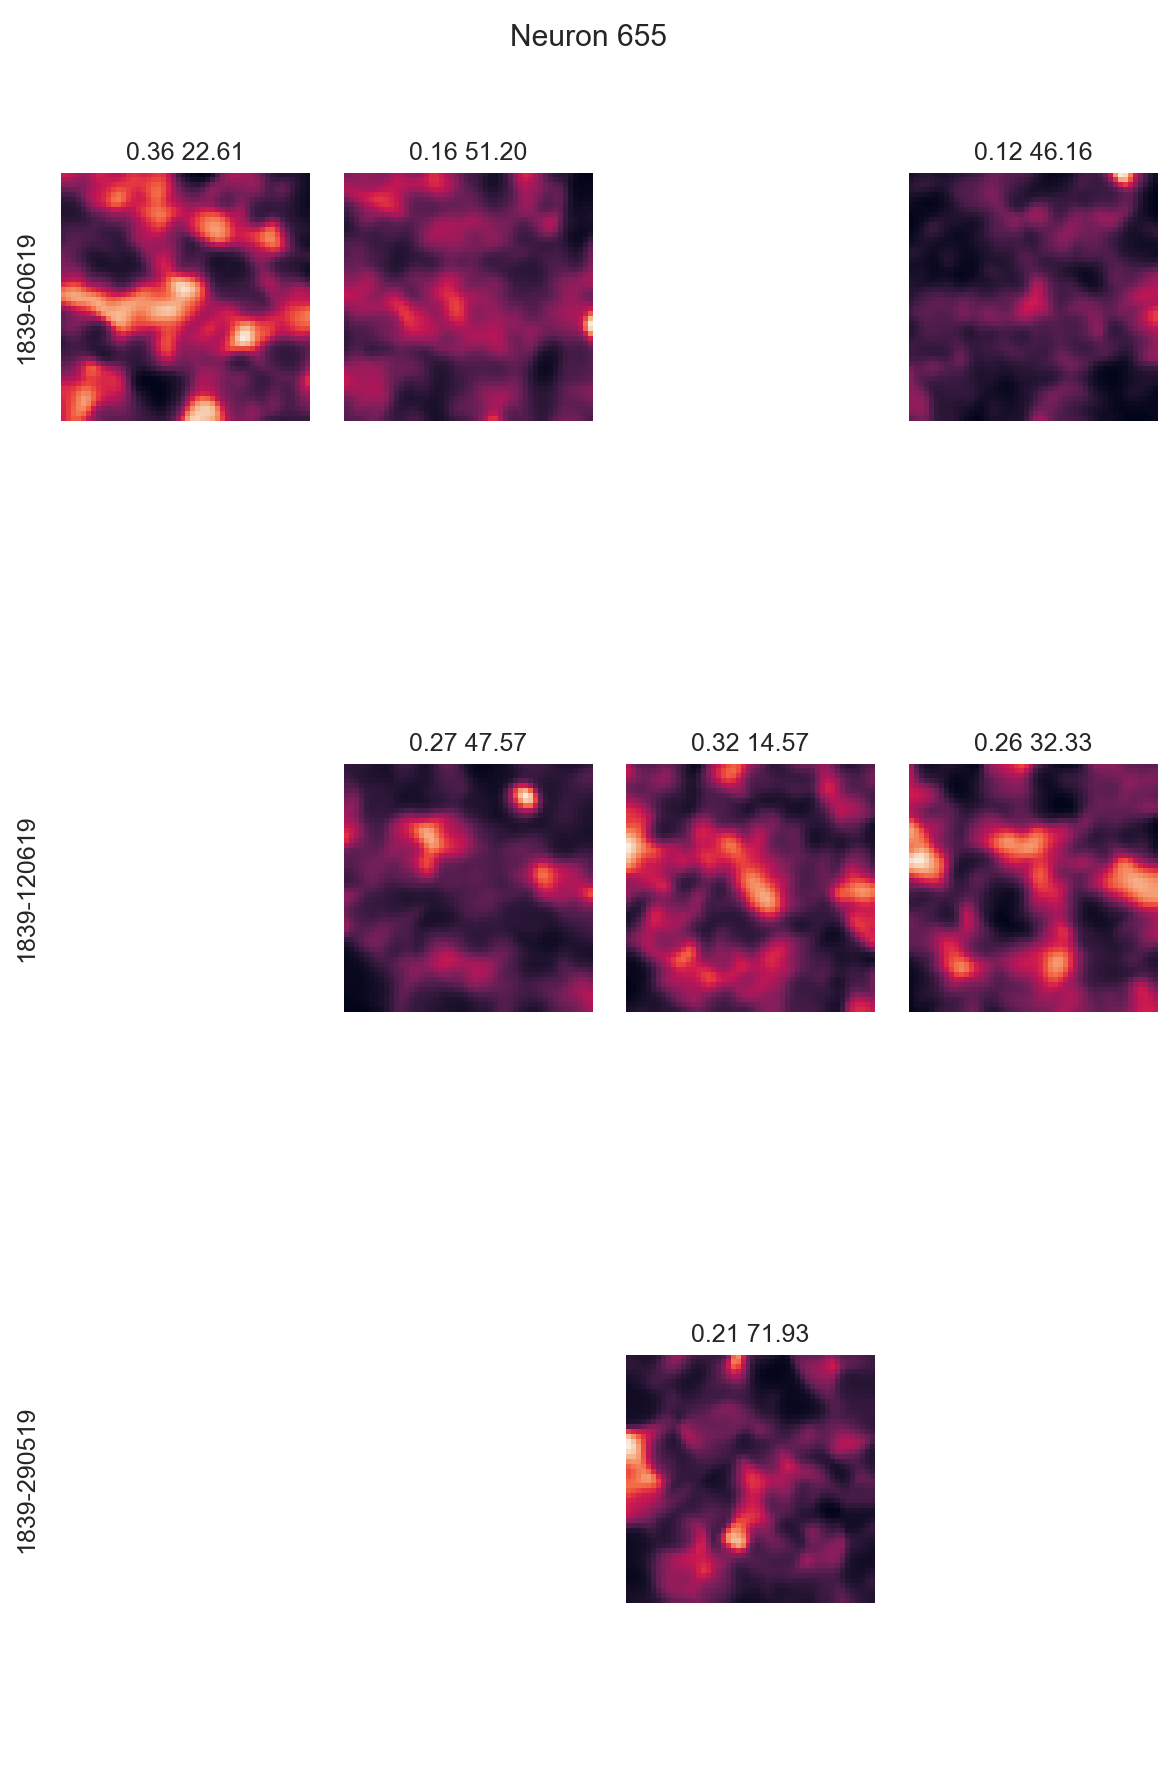

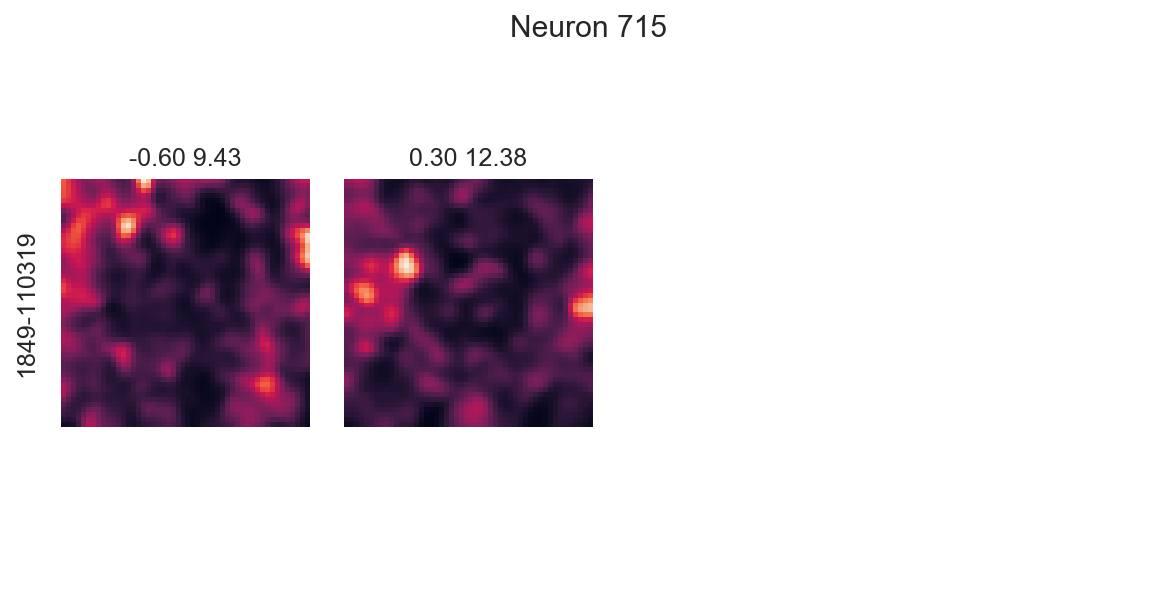

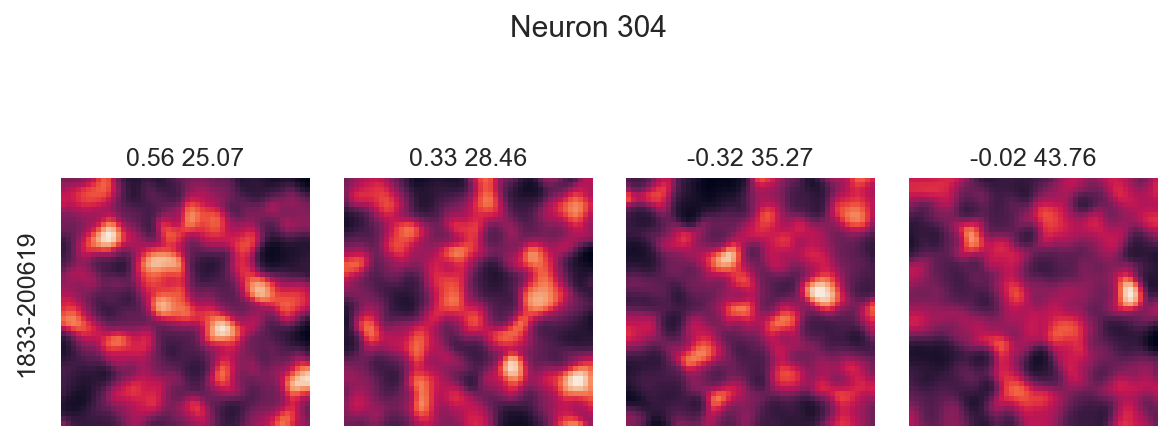

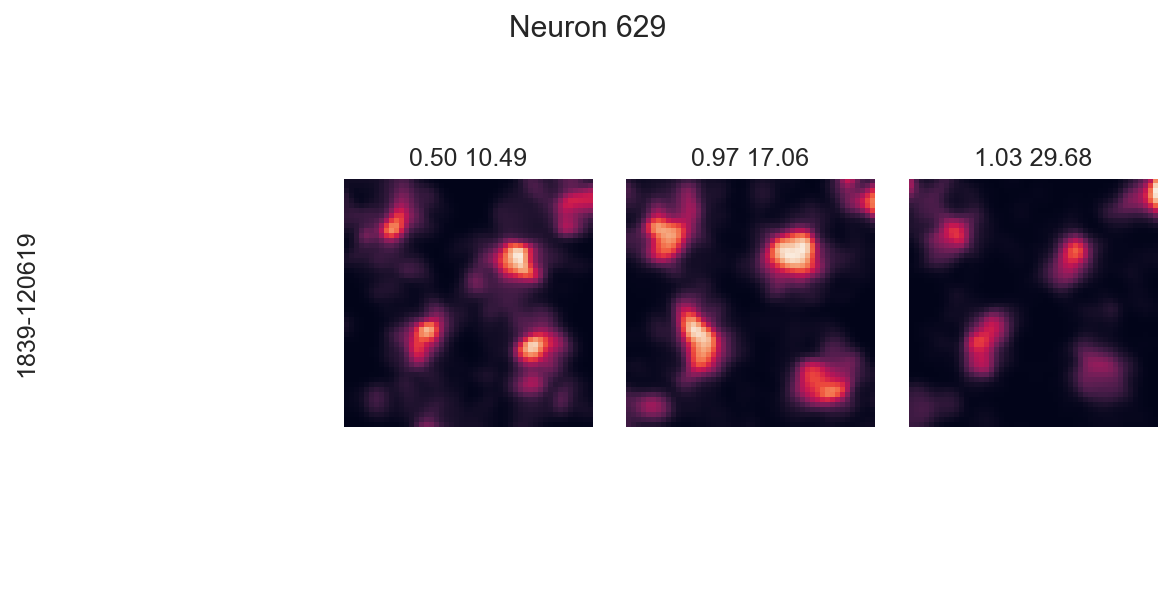

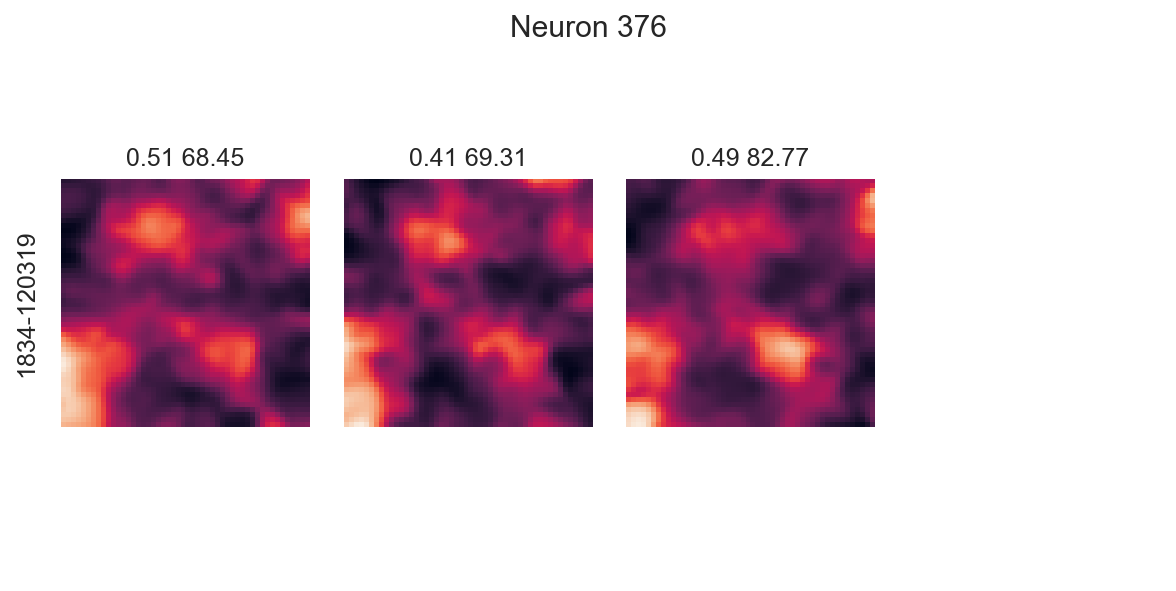

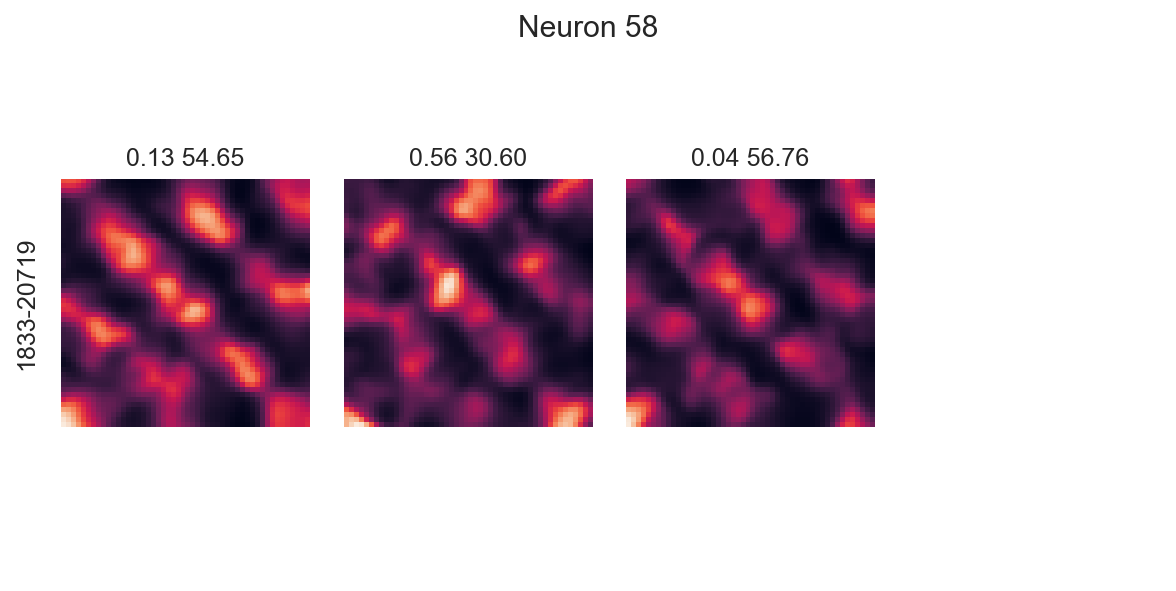

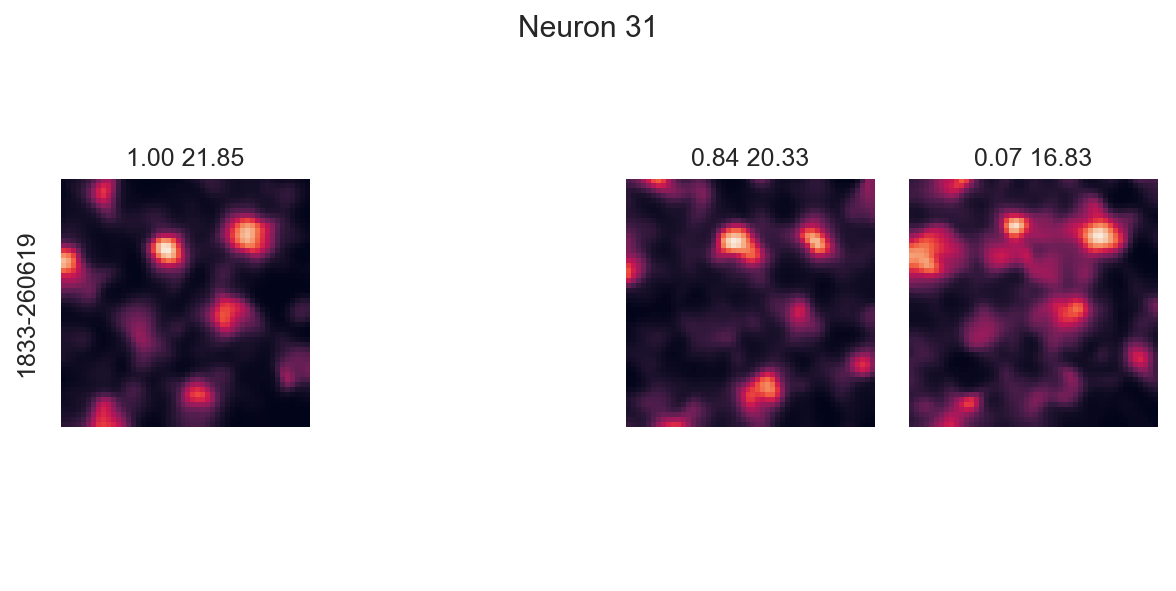

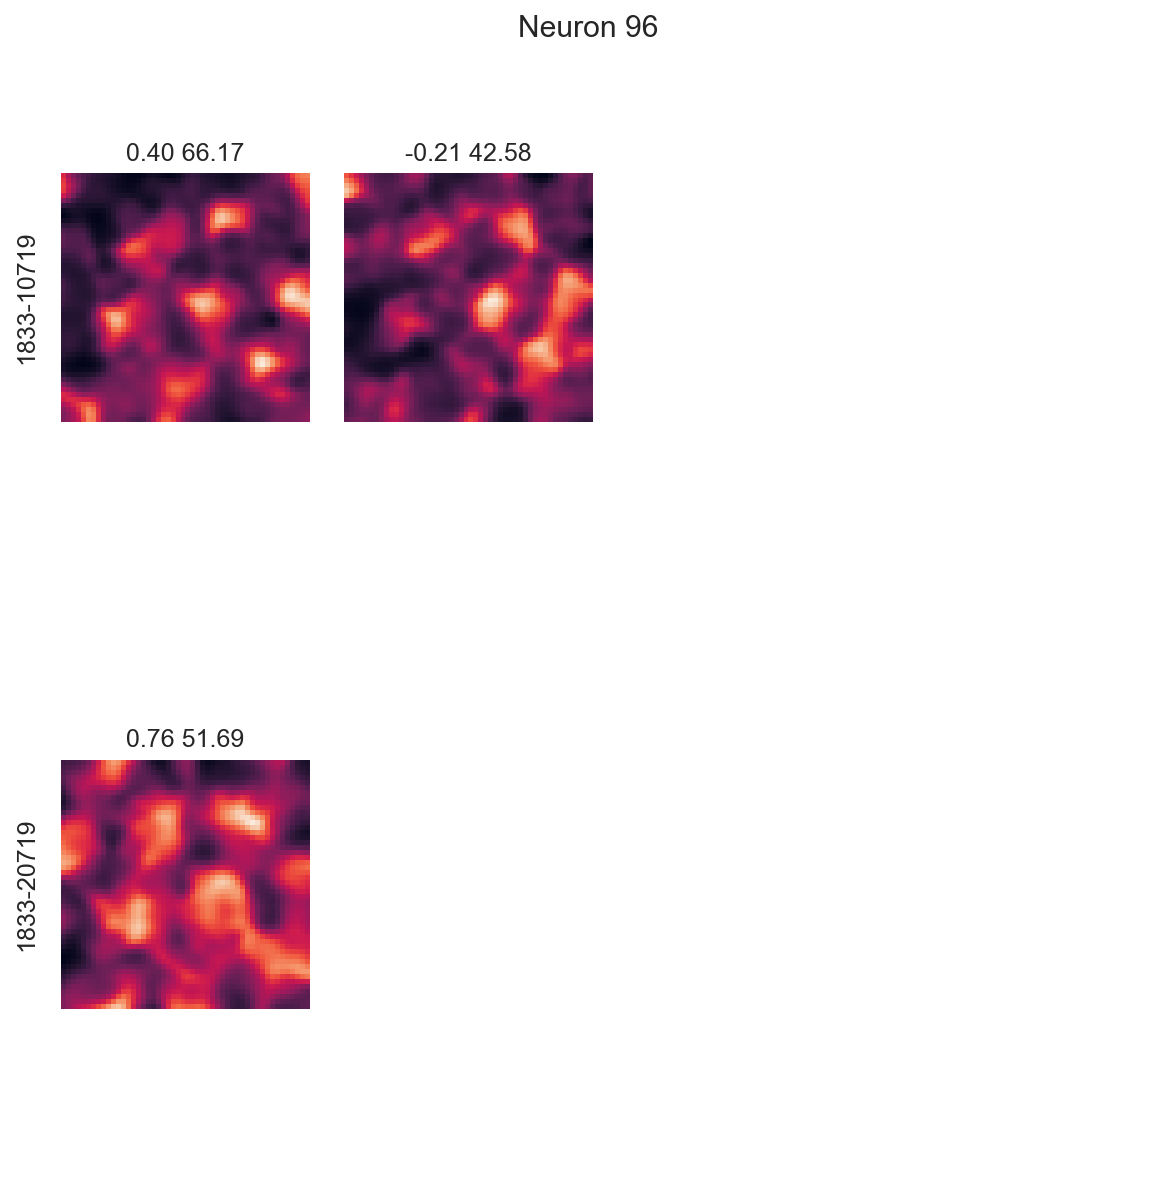

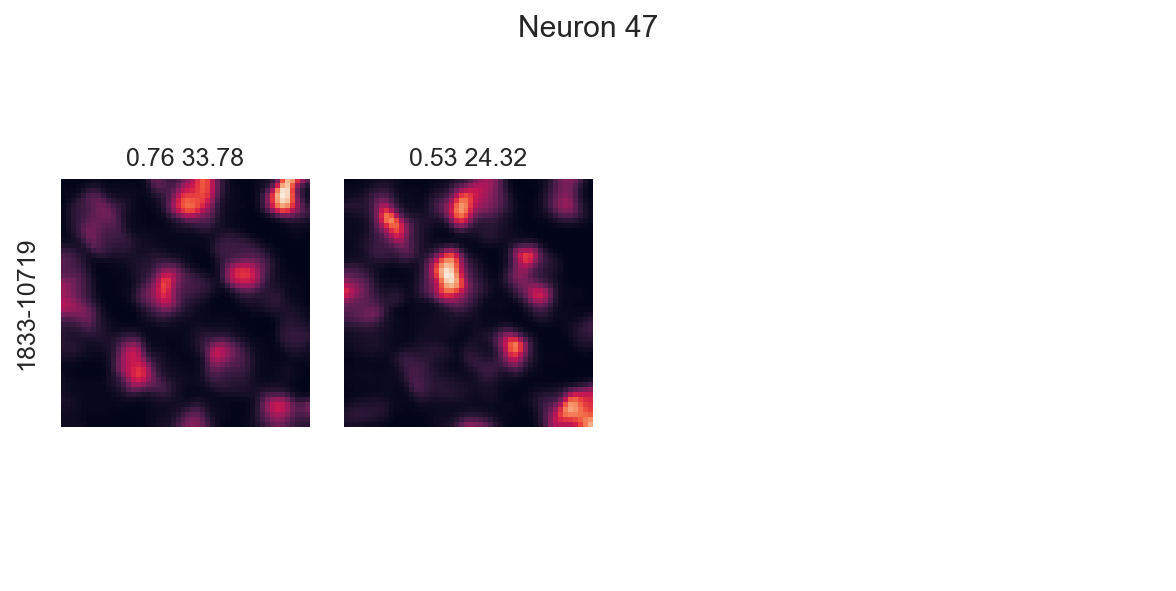

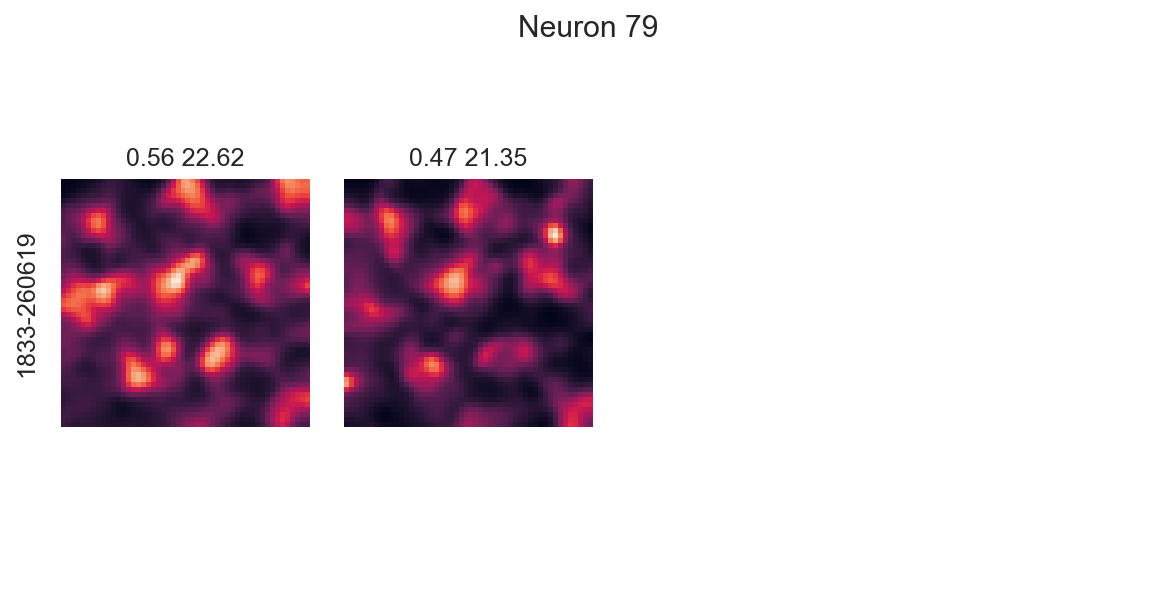

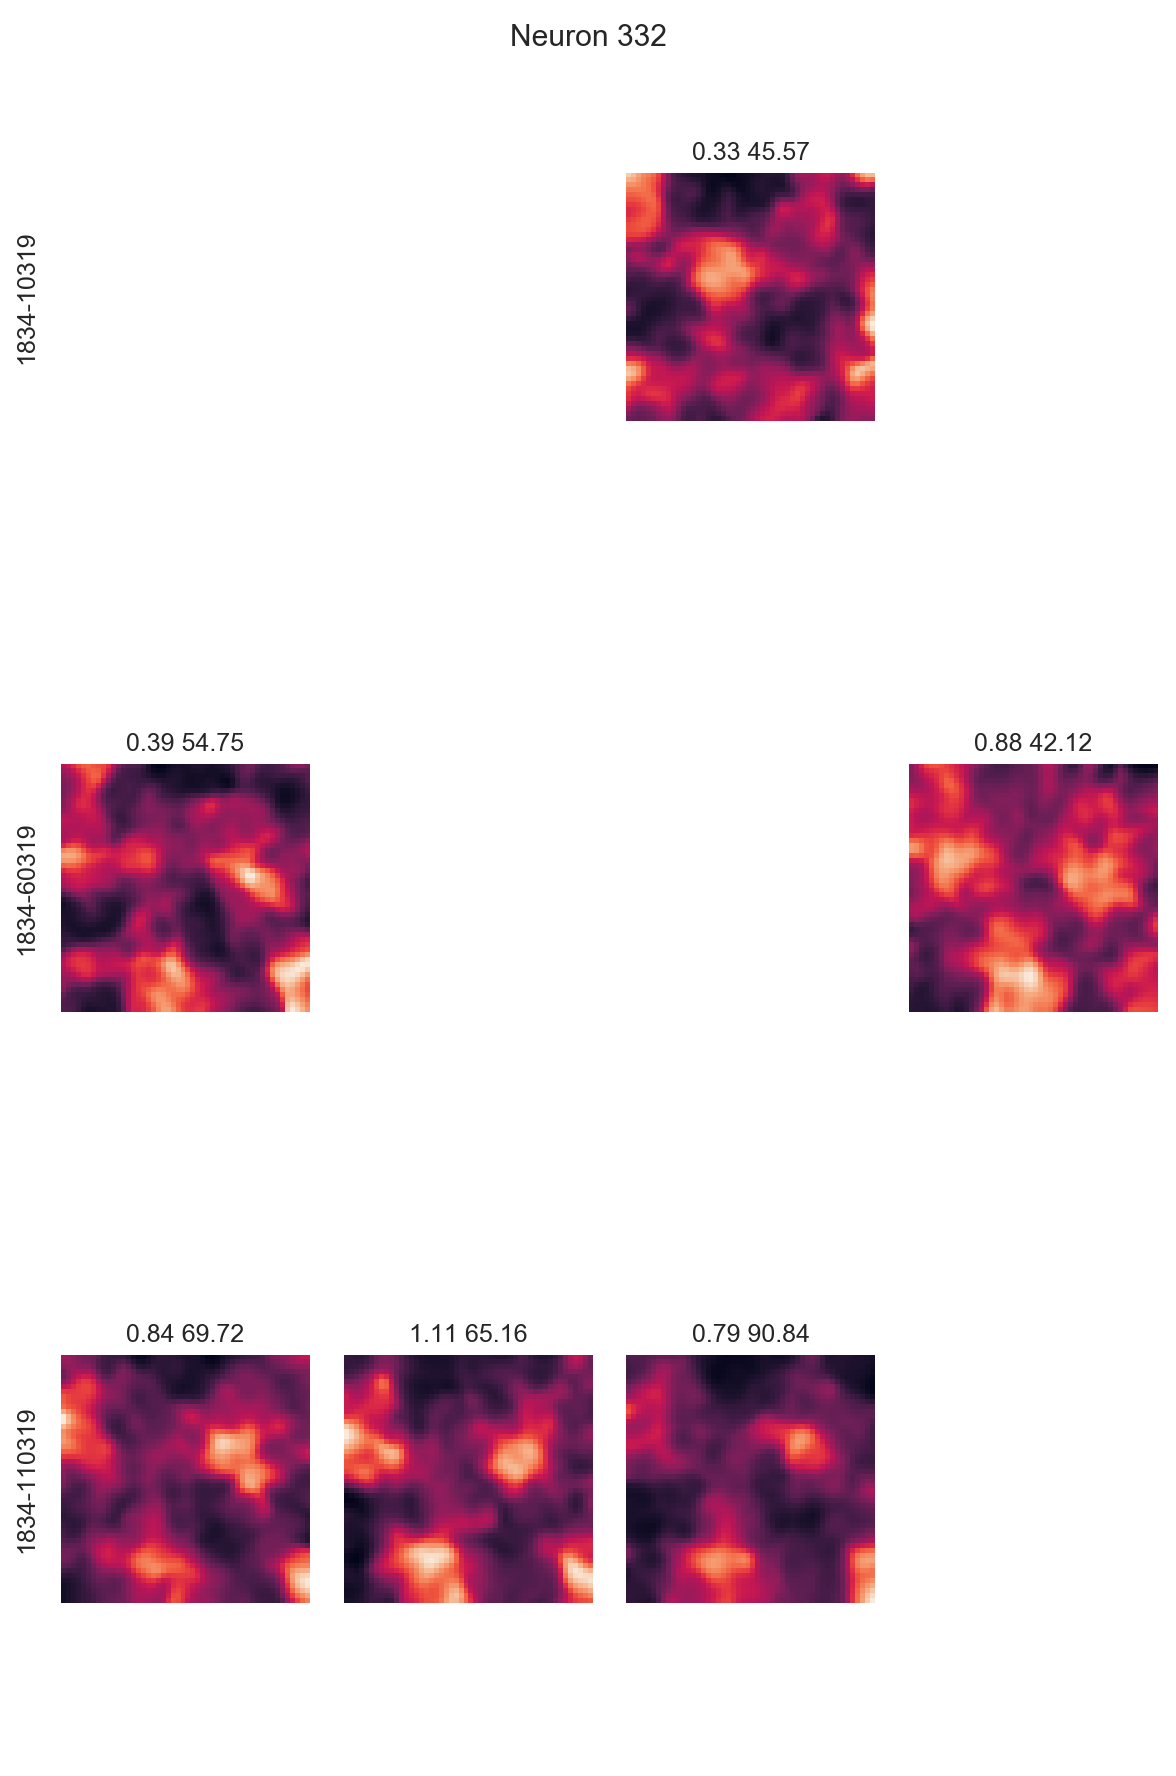

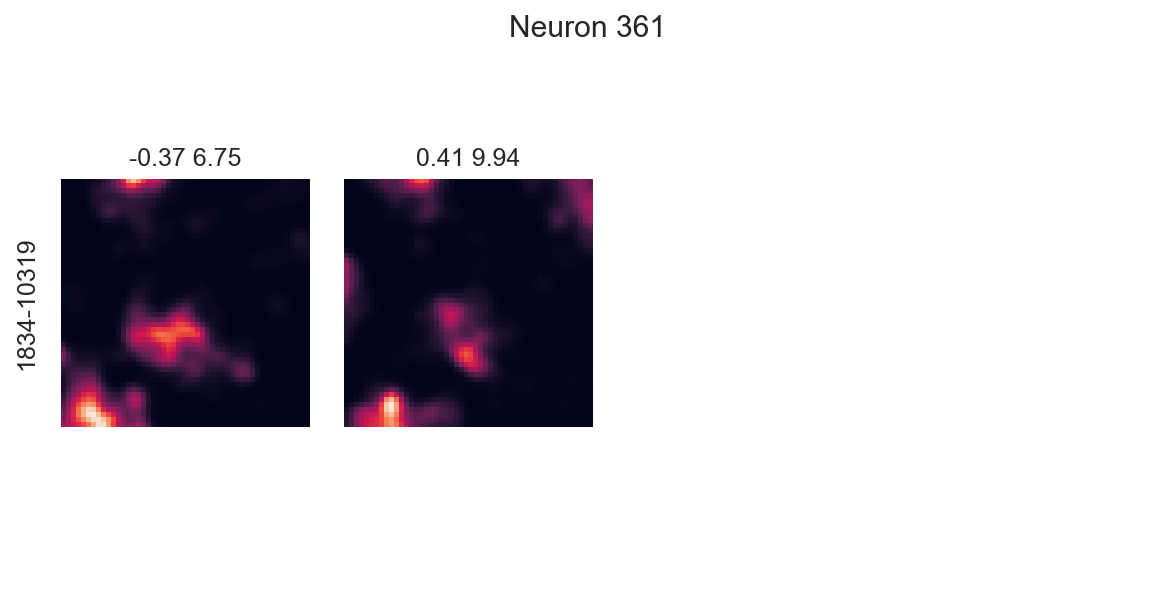

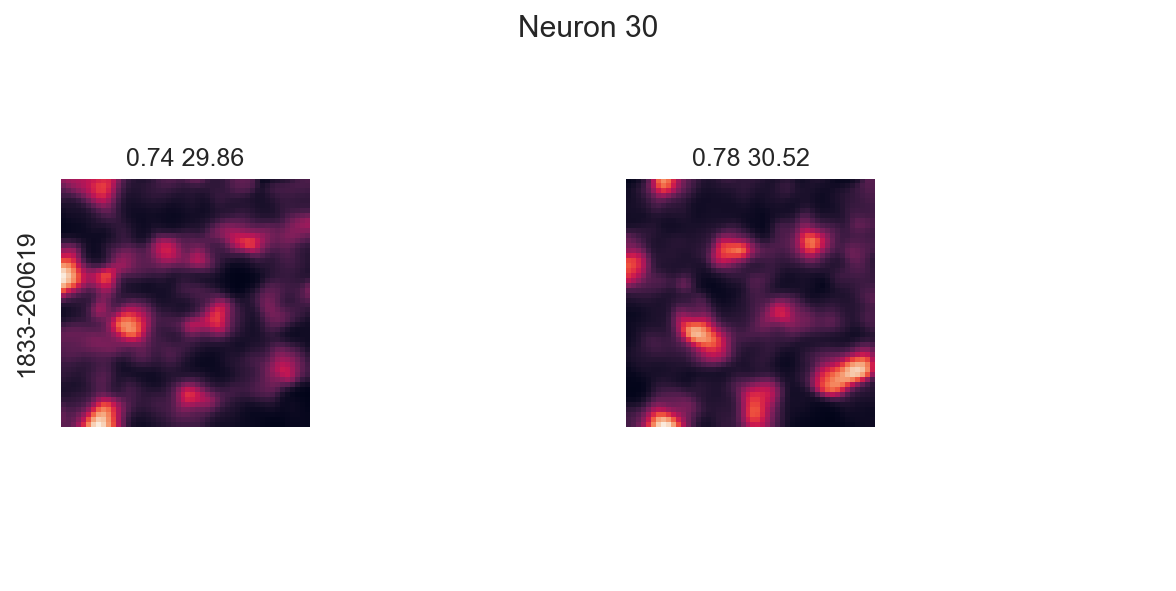

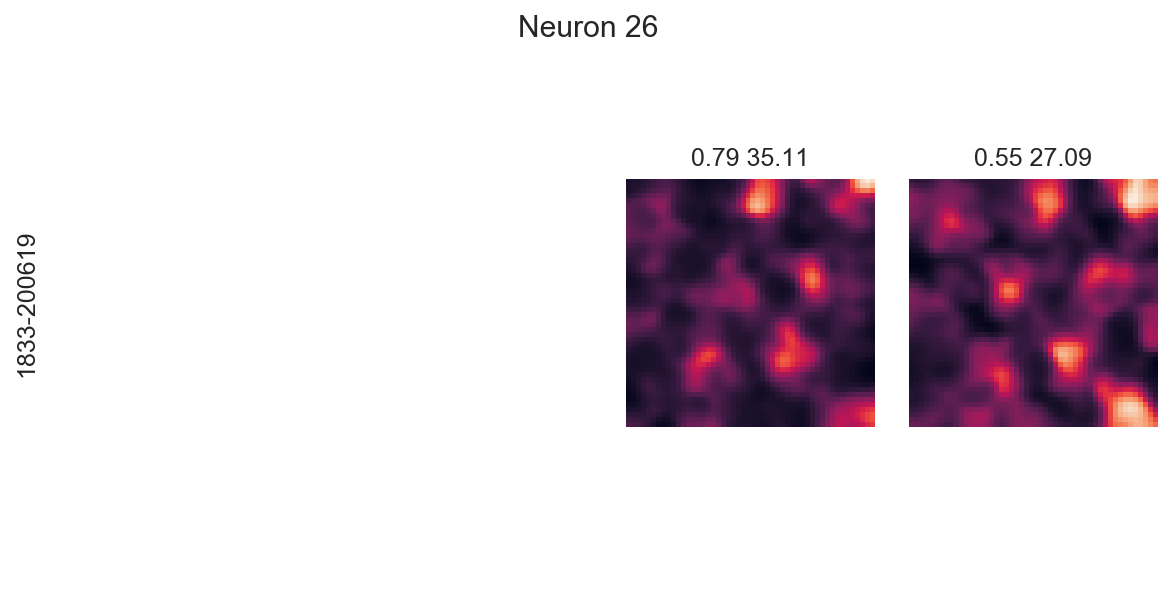

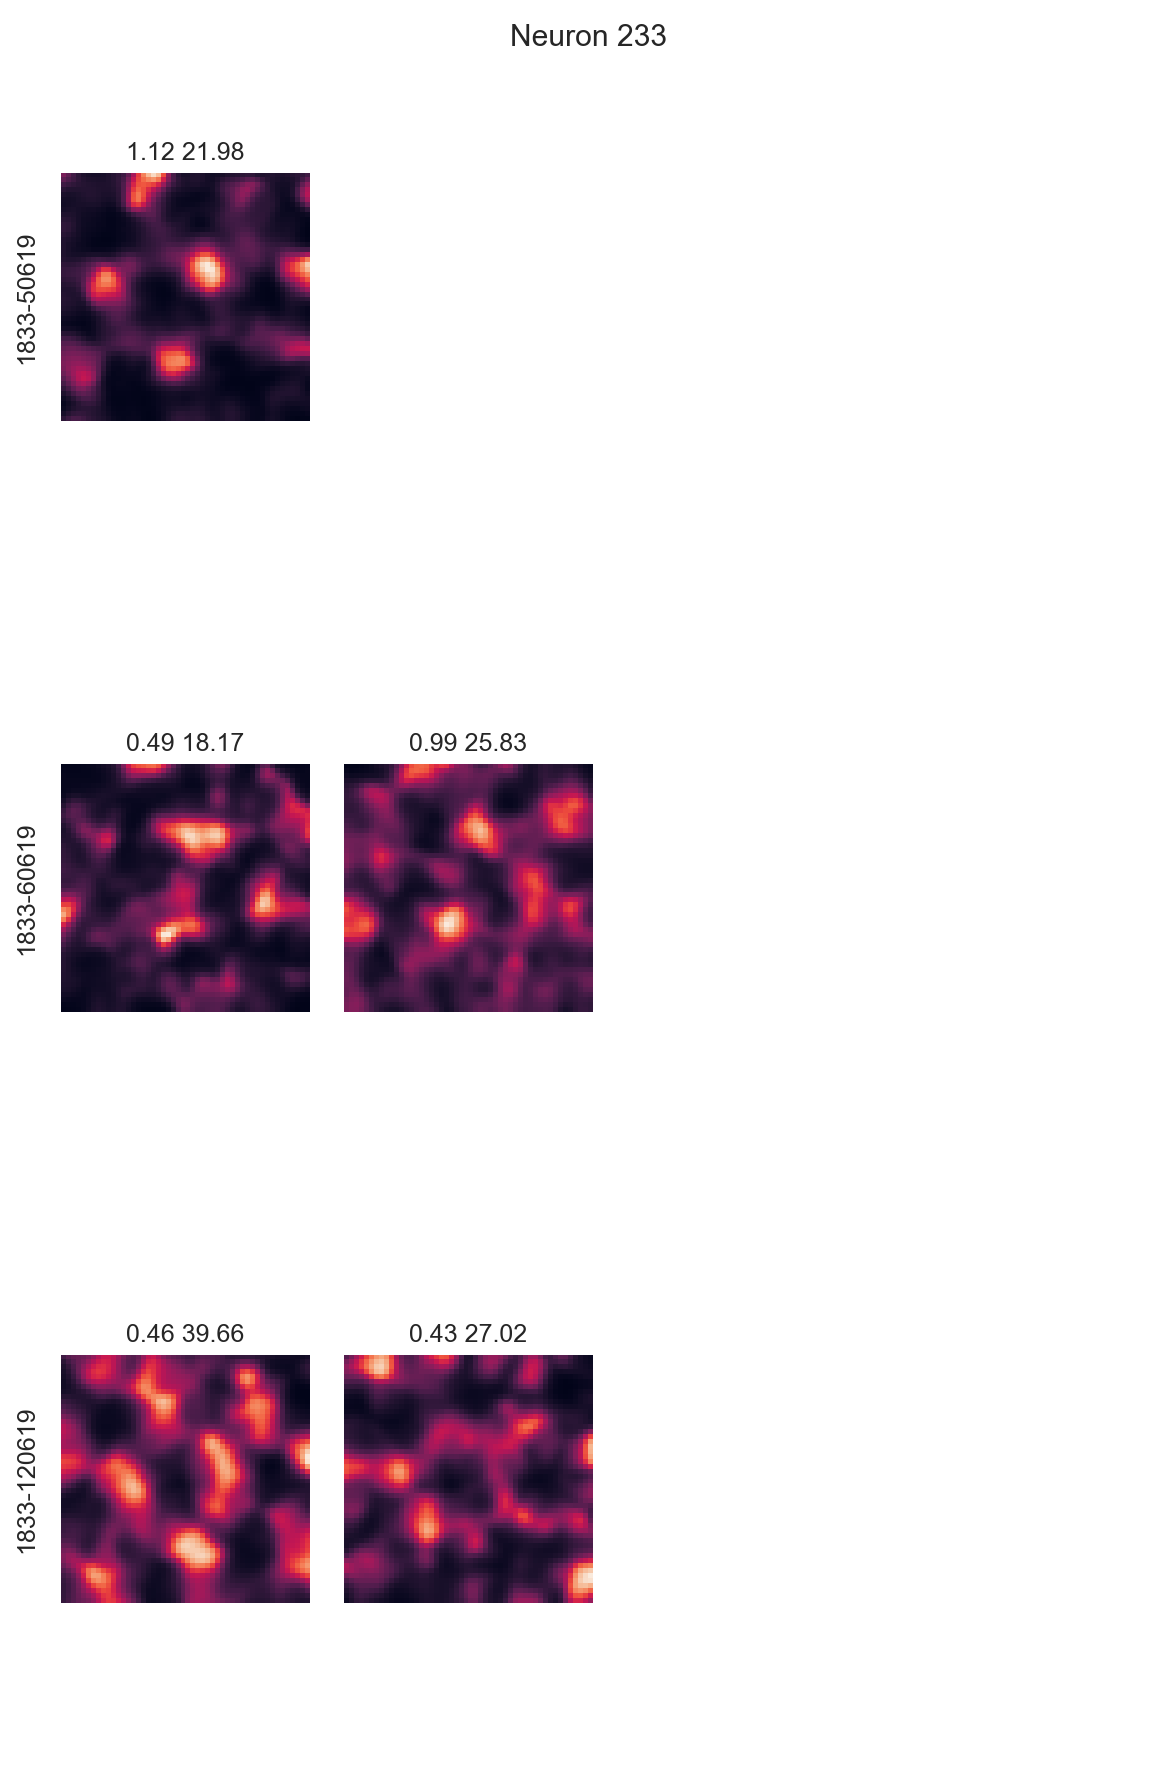

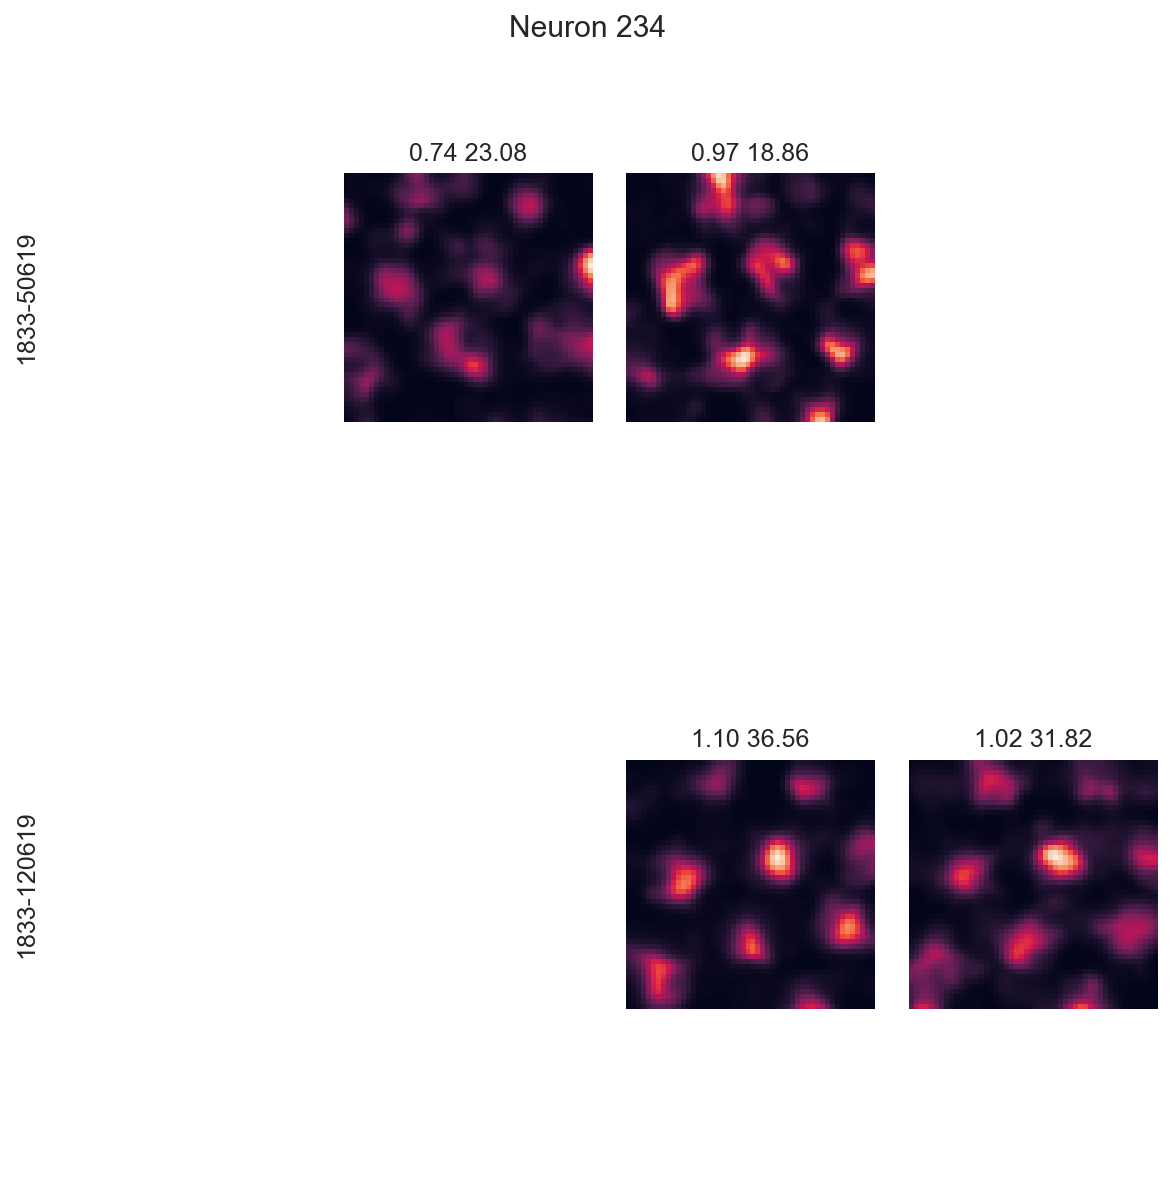

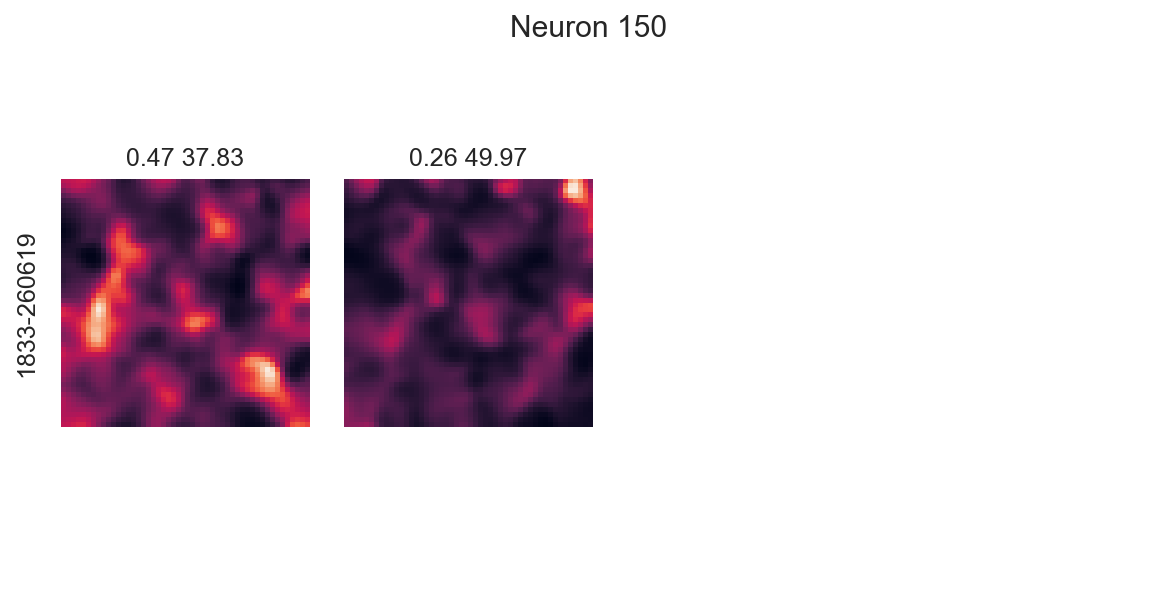

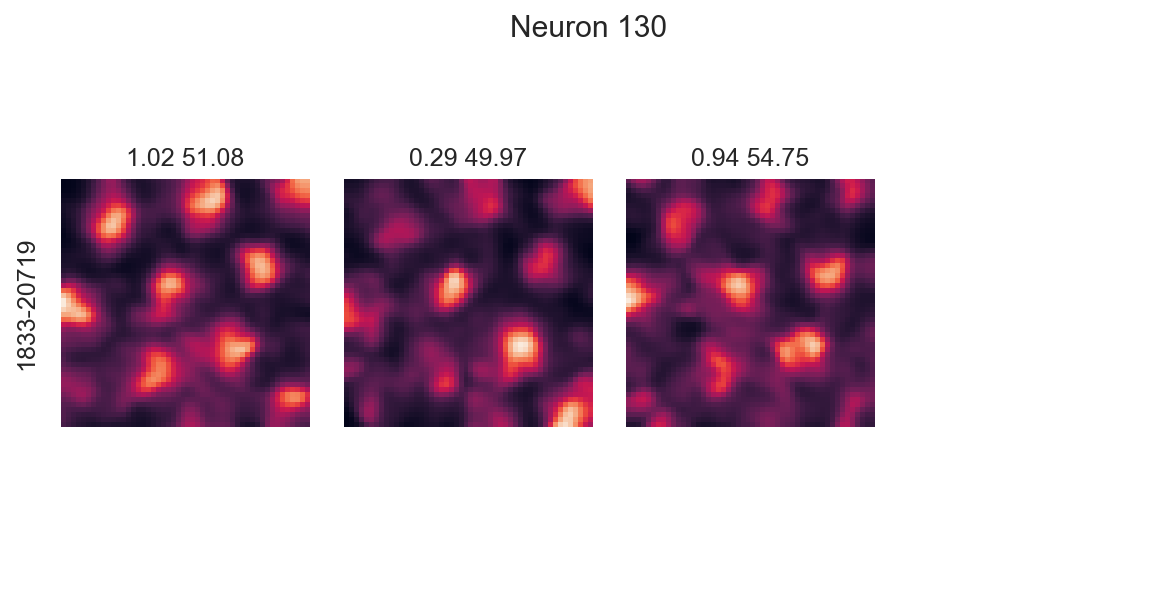

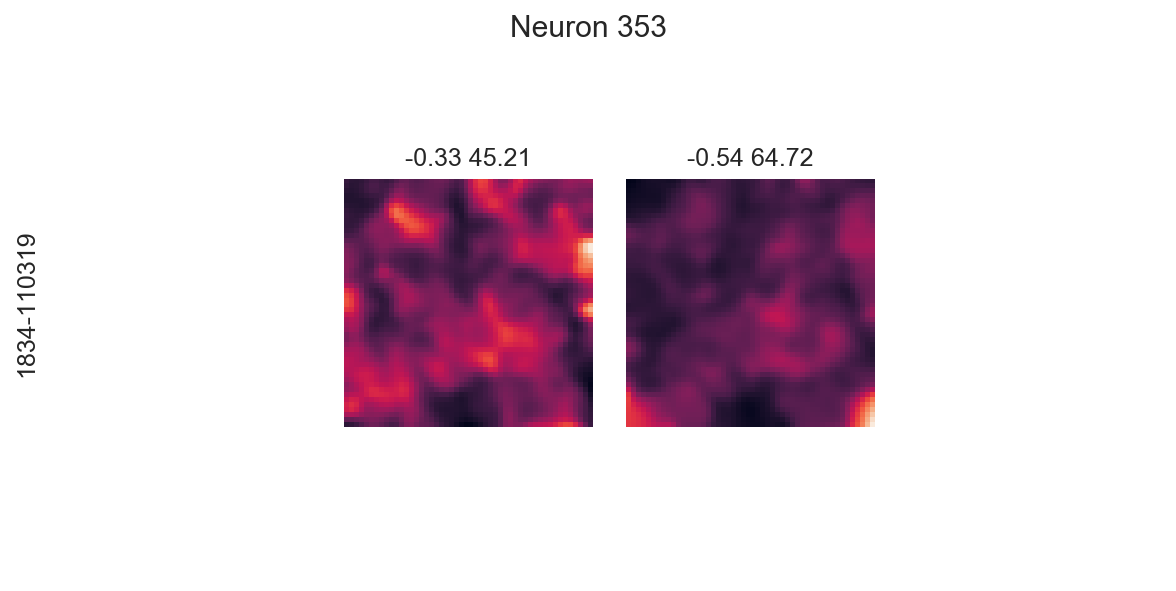

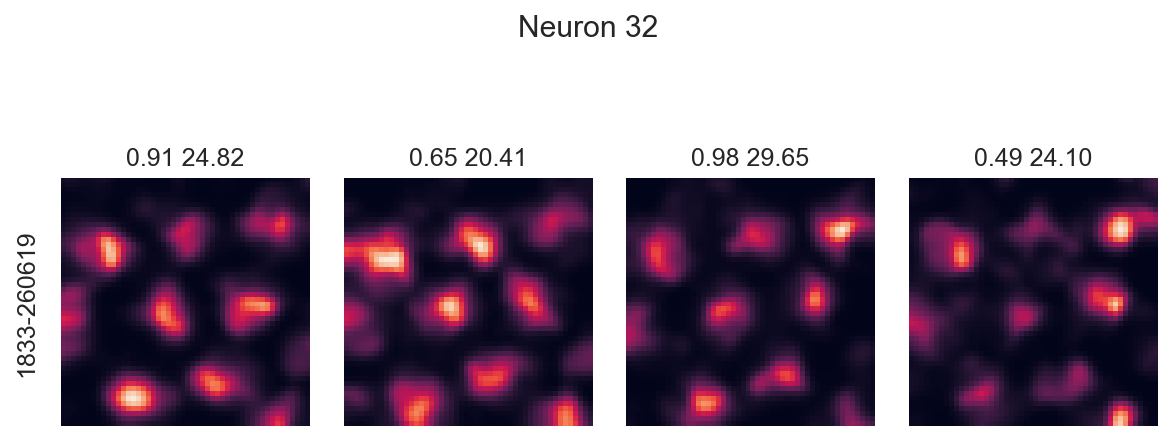

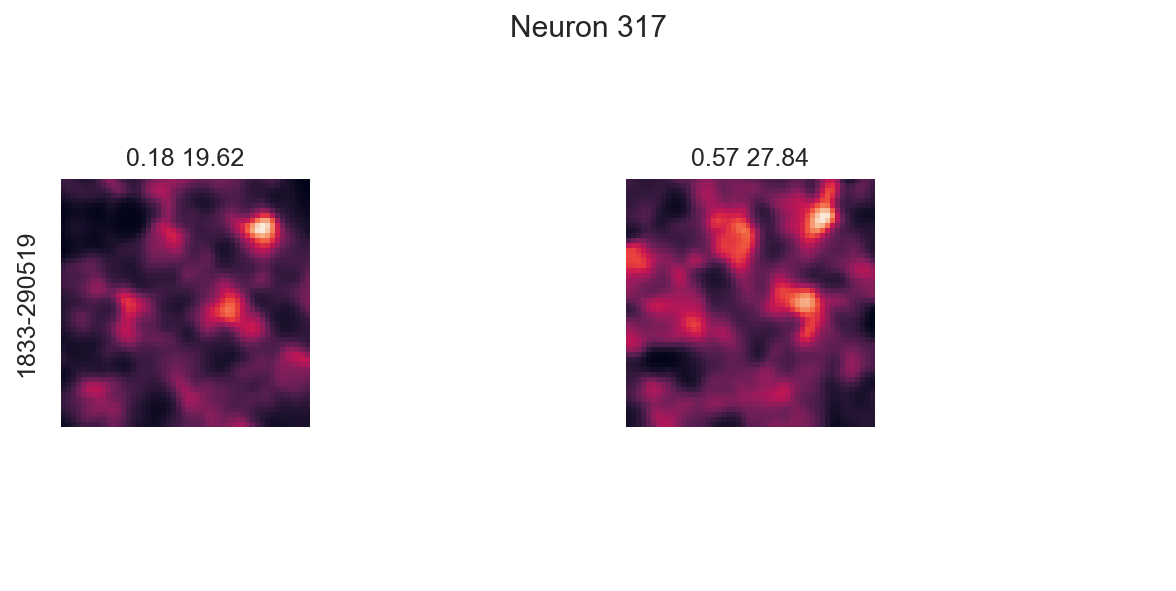

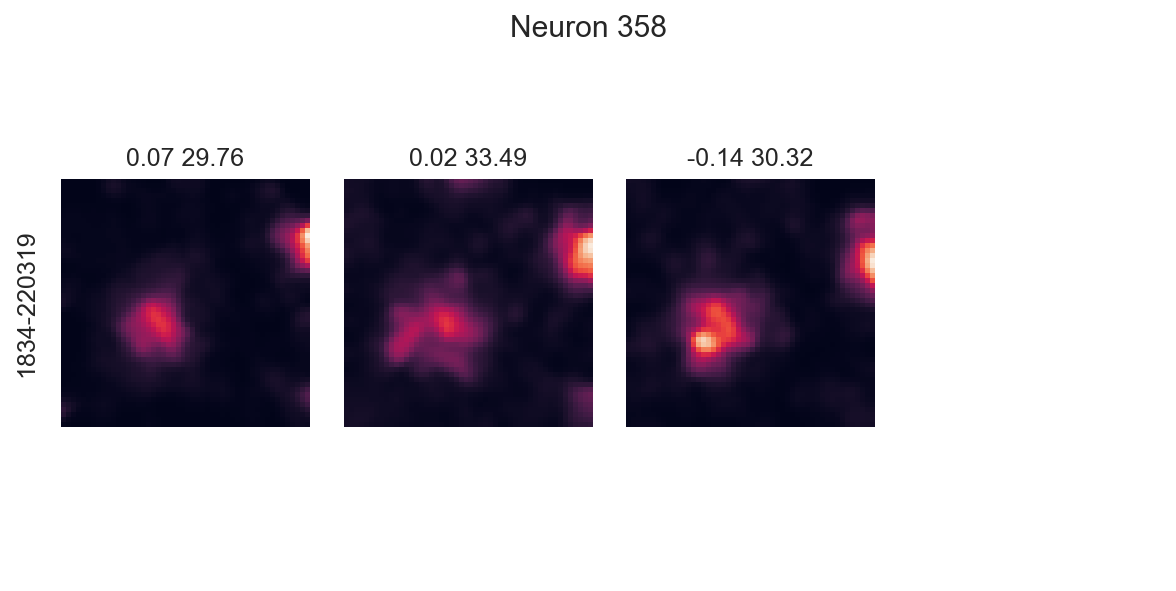

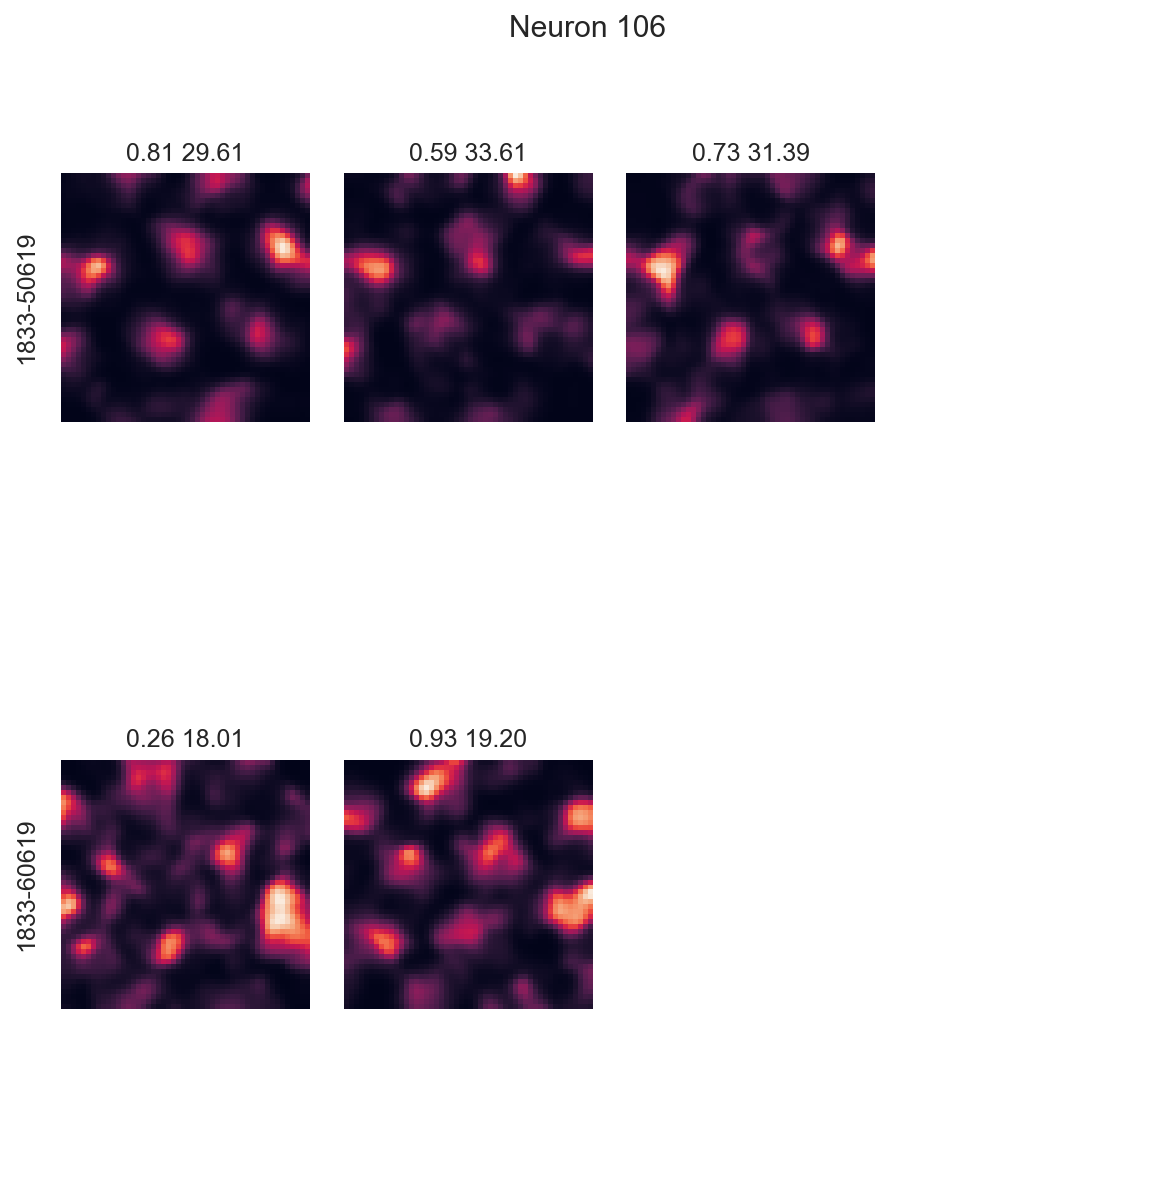

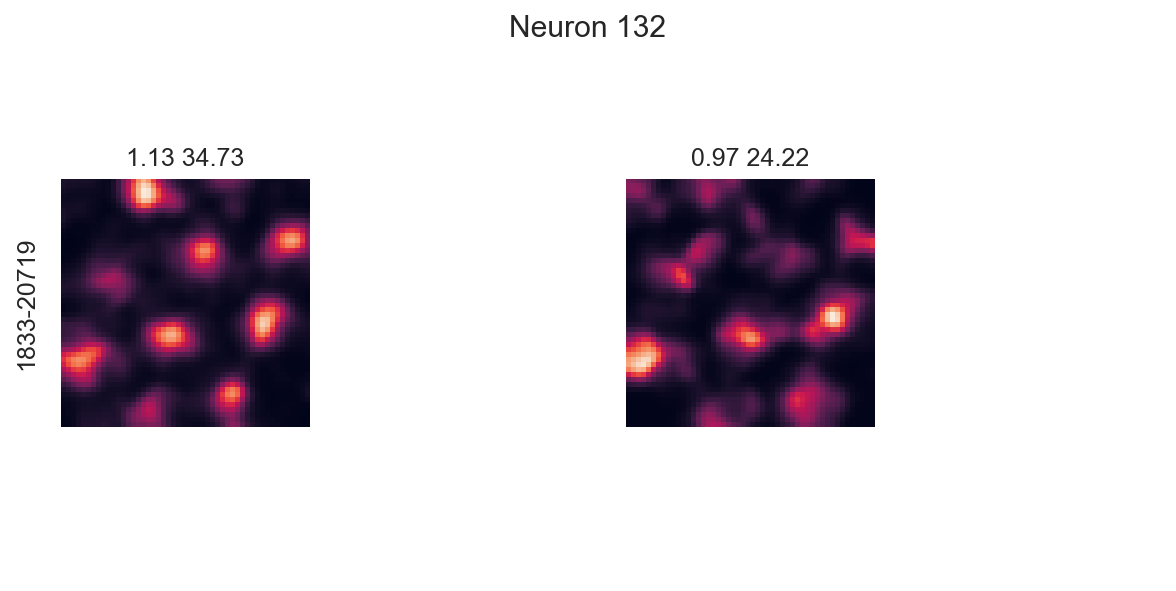

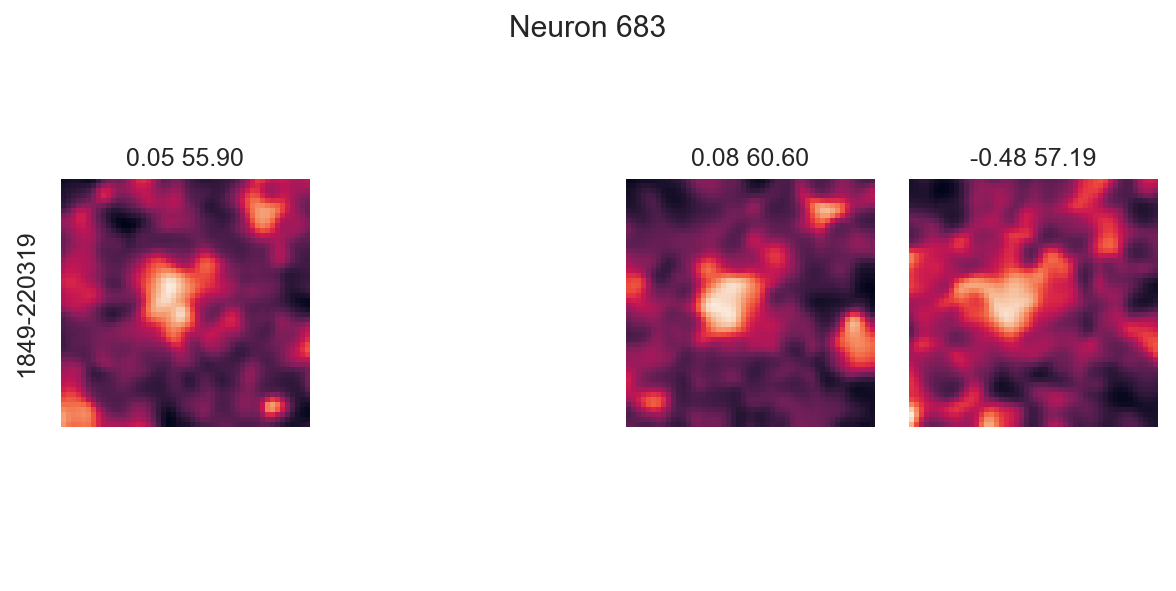

In [21]:
for unit_id, id_num in results_id_map.items():
    sessions = once_a_gridcell.query(f'unit_id=="{unit_id}"')
    n_action = sessions.date.nunique()
    fig, axs = plt.subplots(n_action, 4, sharey=True, sharex=True, figsize=(8, n_action*4))
    sns.despine(left=True, bottom=True)
    fig.suptitle(f'Neuron {id_num}')
    if n_action == 1:
        axs = [axs]
    waxs = None
    for ax, (date, rows) in zip(axs, sessions.groupby('date')):
        entity = rows.iloc[0].entity
        ax[0].set_ylabel(f'{entity}-{date}')
        for _, row in rows.iterrows():
            action_id = row['action']
            channel_id = row['channel_group']
            unit_name = row['unit_name']
            rate_map = data_loader.rate_map(action_id, channel_id, unit_name, smoothing_low)
            idx = row.session_id
            ax[idx].imshow(rate_map, origin='lower')
            ax[idx].set_title(f'{row.gridness:.2f} {row.max_rate:.2f}')
            ax[idx].set_yticklabels([])
            ax[idx].set_xticklabels([])
    plt.tight_layout()
    fig.savefig(output_path / 'figures' / f'neuron_{id_num}_rate_map.png', bbox_inches='tight')
    fig.savefig(output_path / 'figures' / f'neuron_{id_num}_rate_map.svg', bbox_inches='tight')
            
        # waveforms
#         template = data_loader.template(action_id, channel_id, unit_name)
#         if waxs is None:
#             wfig, waxs = plt.subplots(1, template.data.shape[0], sharey=True, sharex=True)
#         for i, wax in enumerate(waxs):
#             wax.plot(template.data[i,:]) 
#             if i > 0:
#                 ax.set_yticklabels([])

In [ ]:
from scipy.interpolate import interp1d


for unit_id, id_num in results_id_map.items():
    sessions = once_a_gridcell.query(f'unit_id=="{unit_id}"')
    n_action = sessions.date.nunique()
    fig, axs = plt.subplots(n_action, 4, sharey=True, sharex=True, figsize=(8, n_action*4))
    sns.despine(left=True, bottom=True)
    fig.suptitle(f'Neuron {id_num}')
    if n_action == 1:
        axs = [axs]
    waxs = None
    for ax, (date, rows) in zip(axs, sessions.groupby('date')):
        entity = rows.iloc[0].entity
        ax[0].set_ylabel(f'{entity}-{date}')
        for _, row in rows.iterrows():
            action_id = row['action']
            channel_id = row['channel_group']
            unit_name = row['unit_name']
            idx = row.session_id
            x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])
            ax[idx].plot(x, y, 'k', alpha=0.3)
            spike_times = data_loader.spike_train(action_id, channel_id, unit_name)
            spike_times = spike_times[(spike_times > min(t)) & (spike_times < max(t))]
            x_spike = interp1d(t, x)(spike_times)
            y_spike = interp1d(t, y)(spike_times)
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            ax[idx].scatter(x_spike, y_spike, marker='.', color=(0.7, 0.2, 0.2), s=1.5)
            ax[idx].set_title(f'{row.session}')
            ax[idx].set_yticklabels([])
            ax[idx].set_xticklabels([])
            for a in ax:
                a.set_aspect(1)
    plt.tight_layout()
    fig.savefig(
        output_path / 'figures' / f'neuron_{id_num}_spike_map.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'neuron_{id_num}_spike_map.svg', 
        bbox_inches='tight')

In [ ]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})
cmap = ['#1b9e77','#d95f02','#7570b3']

In [ ]:
len(results_gridness)

In [ ]:
msize = 9
fig = plt.figure()
ticks = []
nuids = {}
n = 0
for i, pairs in enumerate(results_gridness):
    for j, pair in enumerate(pairs):
        nuid = results_unit_id[i][j]
        if nuid not in nuids:
            nuids[nuid] = n
            n += 1
        plt.plot(
            nuids[nuid], np.diff(pair), 
            color=cmap[i], marker='.', ls='none', markersize=msize)
for l in range(n):
    plt.axvline(l, color='k', lw=.1, alpha=.5)

from matplotlib.lines import Line2D

labels = ['Baseline I vs baseline II', 'Baseline I vs stim I', 'Baseline II vs stim II']
custom_lines = [
    Line2D([],[], color=cmap[i], marker='.', ls='none', label=label, markersize=msize) 
    for i, label in enumerate(labels)
]
plt.ylabel('Difference in gridness')
plt.xlabel('Neuron')
plt.legend(handles=custom_lines, bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
fig.savefig(output_path / 'figures' / 'neuron_gridness.png', bbox_inches='tight')
fig.savefig(output_path / 'figures' / 'neuron_gridness.svg', bbox_inches='tight')

In [ ]:
fig = plt.figure()
labels = ['Baseline I vs baseline II', 'Baseline I vs stim I', 'Baseline II vs stim II']
for i, pairs in enumerate(results_gridness):
    for j, pair in enumerate(pairs):
        plt.plot(*pair, color=cmap[i], marker='.', ls='none', markersize=msize)
#     plt.scatter(*np.array(pairs).T, label=labels[i], color=cmap[i])
# plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
custom_lines = [
    Line2D([],[], color=cmap[i], marker='.', ls='none', label=label, markersize=msize) 
    for i, label in enumerate(labels)
]
plt.legend(handles=custom_lines, bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
plt.ylabel('Gridness')
plt.xlabel('Baseline gridness')
lim = [-.7, 1.35]
plt.ylim(lim)
plt.xlim(lim)
plt.plot(lim, lim, '--k', alpha=.5, lw=1)
fig.savefig(output_path / 'figures' / 'baseline_gridness_vs_other.png', bbox_inches='tight')
fig.savefig(output_path / 'figures' / 'baseline_gridness_vs_other.svg', bbox_inches='tight')

In [ ]:
fig = plt.figure()
import matplotlib
cNorm  = matplotlib.colors.Normalize(vmin=-np.pi/2, vmax=np.pi/2)
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=plt.cm.Blues)

ticks = []
for i, pairs in enumerate(results_gridness):
    for j, pair in enumerate(pairs):
        angle = float(np.arctan(np.diff(pair) / 0.9))
        color = scalarMap.to_rgba(angle)
#         color = plt.cm.Paired((np.sign(angle)+1)/14)
        tick = (i, i+.8)
        plt.plot(tick, pair, marker='.', color=color)
    ticks.append(tick)
plt.xticks(
    [t for tick in ticks for t in tick], 
    ['Baseline I', 'Baseline II', 'Baseline I', 'Stimulation I', 'Baseline II', 'Stimulation II'],
    rotation=-45, ha='left'
)
plt.ylabel('Gridness')
fig.savefig(output_path / 'figures' / 'stickplot_gridness.png', bbox_inches='tight')
fig.savefig(output_path / 'figures' / 'stickplot_gridness.svg', bbox_inches='tight')

In [ ]:
fig = plt.figure()
ticks = [0,0.6,1.2]

diff_res = [[], [], []]
for i, pairs in enumerate(results_gridness):
    for j, pair in enumerate(pairs):
#         if results_unit_id[i][j] in [results_id_map[i] for i in exclude]:
#             continue
        diff_res[i].append(np.diff(pair))
violins = plt.violinplot(
    diff_res, ticks, showmedians=True, showextrema=False, points=1000, bw_method=.2)


for category in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
    if category in violins:
        violins[category].set_color(['k', 'k'])
        violins[category].set_linewidth(2.0)
        
colors = plt.cm.Paired(np.linspace(0,1,12))
            
for pc, c in zip(violins['bodies'], cmap):
    pc.set_facecolor(c)
    pc.set_edgecolor(c)
    
plt.xticks(ticks, ['baseline', 'stim i', 'stim ii'])
plt.ylabel('Difference in gridness')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
fig.savefig(output_path / 'figures' / 'violins_gridness_difference.png', bbox_inches='tight')
fig.savefig(output_path / 'figures' / 'violins_gridness_difference.svg', bbox_inches='tight')

# Save to expipe

In [ ]:
action = project.require_action("longitudinal-comparisons-gridcells")

In [ ]:
copy_tree(output_path, str(action.data_path()))

In [ ]:
septum_mec.analysis.registration.store_notebook(action, "20_longitudinal_comparisons_gridcells.ipynb")